# Определение стоимости автомобилей

## Описание и цель проекта

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## План исследования

- Подготовка данных
- Обучение моделей
- Анализ моделей
- Вывод

## Установка и импорт необходимых библиотек

In [1]:
!pip install numpy==1.24.3

In [2]:
!pip install scikit-learn==1.4.0

In [3]:
!pip install phik

In [4]:
!pip install lightgbm

In [5]:
!pip install catboost

In [6]:
!pip install xgboost

In [7]:
# common
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#correlation
import phik

# pipeline & preprocessing
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    OneHotEncoder,
    LabelEncoder,
    OrdinalEncoder,
    StandardScaler,
    MinMaxScaler,
    RobustScaler
)

#model selection
from sklearn.model_selection import (
    train_test_split,
    RandomizedSearchCV,
    GridSearchCV
)


#models
from sklearn.linear_model import (
    LinearRegression, 
)
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor

from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

#metrics
from sklearn.metrics import (
    root_mean_squared_error
)

from sklearn.impute import SimpleImputer


## Подготовка данных

### Загрузка и предпросмотр данных

In [8]:
try:
    df = pd.read_csv('/datasets/autos.csv')
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')
df.head()    

DateCrawled  Price VehicleType  RegistrationYear Gearbox  Power  \
0  2016-03-24 11:52:17    480         NaN              1993  manual      0   
1  2016-03-24 10:58:45  18300       coupe              2011  manual    190   
2  2016-03-14 12:52:21   9800         suv              2004    auto    163   
3  2016-03-17 16:54:04   1500       small              2001  manual     75   
4  2016-03-31 17:25:20   3600       small              2008  manual     69   

   Model  Kilometer  RegistrationMonth  FuelType       Brand Repaired  \
0   golf     150000                  0    petrol  volkswagen      NaN   
1    NaN     125000                  5  gasoline        audi      yes   
2  grand     125000                  8  gasoline        jeep      NaN   
3   golf     150000                  6    petrol  volkswagen       no   
4  fabia      90000                  7  gasoline       skoda       no   

           DateCreated  NumberOfPictures  PostalCode             LastSeen  
0  2016-03-24 00:00:00                 0       70435  2016-04-07 03:16:57  
1  2016-03-24 00:00:00                 0       66954  2016-04-07 01:46:50  
2  2016-03-14 00:00:00                 0       90480  2016-04-05 12:47:46  
3  2016-03-17 00:00:00                 0       91074  2016-03-17 17:40:17  
4  2016-03-31 00:00:00                 0       60437  2016-04-06 10:17:21

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Видны пропусти, несоответсвие типов данных (даты), плохой стиль названий столбцов - данным нужна предобработка 

### Предобработка данных

#### Работа с именами столбцов

In [10]:
df.columns = df.columns.str.replace('(?<=[a-z])(?=[A-Z])', '_', regex=True).str.lower()
df.head()

date_crawled  price vehicle_type  registration_year gearbox  power  \
0  2016-03-24 11:52:17    480          NaN               1993  manual      0   
1  2016-03-24 10:58:45  18300        coupe               2011  manual    190   
2  2016-03-14 12:52:21   9800          suv               2004    auto    163   
3  2016-03-17 16:54:04   1500        small               2001  manual     75   
4  2016-03-31 17:25:20   3600        small               2008  manual     69   

   model  kilometer  registration_month fuel_type       brand repaired  \
0   golf     150000                   0    petrol  volkswagen      NaN   
1    NaN     125000                   5  gasoline        audi      yes   
2  grand     125000                   8  gasoline        jeep      NaN   
3   golf     150000                   6    petrol  volkswagen       no   
4  fabia      90000                   7  gasoline       skoda       no   

          date_created  number_of_pictures  postal_code            last_seen  
0  2016-03-24 00:00:00                   0        70435  2016-04-07 03:16:57  
1  2016-03-24 00:00:00                   0        66954  2016-04-07 01:46:50  
2  2016-03-14 00:00:00                   0        90480  2016-04-05 12:47:46  
3  2016-03-17 00:00:00                   0        91074  2016-03-17 17:40:17  
4  2016-03-31 00:00:00                   0        60437  2016-04-06 10:17:21

#### Работа с пропусками

Посмотрим, где есть пропуски

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        316879 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             334536 non-null  object
 5   power               354369 non-null  int64 
 6   model               334664 non-null  object
 7   kilometer           354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           321474 non-null  object
 10  brand               354369 non-null  object
 11  repaired            283215 non-null  object
 12  date_created        354369 non-null  object
 13  number_of_pictures  354369 non-null  int64 
 14  postal_code         354369 non-null  int64 
 15  last_seen           354369 non-null  object
dtypes:

Начнем с модели: ее пропуск связан с какой-то ошибкой, так как машин без модели не бывает, поэтому заполним константой 

In [12]:
df['model'] = df['model'].fillna('unknown')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        316879 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             334536 non-null  object
 5   power               354369 non-null  int64 
 6   model               354369 non-null  object
 7   kilometer           354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           321474 non-null  object
 10  brand               354369 non-null  object
 11  repaired            283215 non-null  object
 12  date_created        354369 non-null  object
 13  number_of_pictures  354369 non-null  int64 
 14  postal_code         354369 non-null  int64 
 15  last_seen           354369 non-null  object
dtypes:

Далее тип кузова: попробуем поискать в датасете такие же модели и заполнить пропуски в соответствии с заполненными типами кузова

In [13]:
np.sum(df.groupby('model')['vehicle_type'].last() == df.groupby('model')['vehicle_type'].first())

167

Интресно, что некоторые автомобили бывают в разных кузовах, что логично, поэтому попробуем заполнить модой. Все же лучше, чем 10% данных выбрасывать 

In [14]:
df.groupby('model')['vehicle_type'].first().isna().sum()

0

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        316879 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             334536 non-null  object
 5   power               354369 non-null  int64 
 6   model               354369 non-null  object
 7   kilometer           354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           321474 non-null  object
 10  brand               354369 non-null  object
 11  repaired            283215 non-null  object
 12  date_created        354369 non-null  object
 13  number_of_pictures  354369 non-null  int64 
 14  postal_code         354369 non-null  int64 
 15  last_seen           354369 non-null  object
dtypes:

In [16]:
df['vehicle_type'] = df['vehicle_type'].fillna(df.groupby('model')['vehicle_type'].transform(lambda x: x.mode()[0]))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        354369 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             334536 non-null  object
 5   power               354369 non-null  int64 
 6   model               354369 non-null  object
 7   kilometer           354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           321474 non-null  object
 10  brand               354369 non-null  object
 11  repaired            283215 non-null  object
 12  date_created        354369 non-null  object
 13  number_of_pictures  354369 non-null  int64 
 14  postal_code         354369 non-null  int64 
 15  last_seen           354369 non-null  object
dtypes:

Далее тип коробки передач: для каждой модели он может быть любым так, что просто меняем на константу

In [17]:
df['gearbox'].unique()

array(['manual', 'auto', nan], dtype=object)

In [18]:
df['gearbox'] = df['gearbox'].fillna('unknown')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        354369 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             354369 non-null  object
 5   power               354369 non-null  int64 
 6   model               354369 non-null  object
 7   kilometer           354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           321474 non-null  object
 10  brand               354369 non-null  object
 11  repaired            283215 non-null  object
 12  date_created        354369 non-null  object
 13  number_of_pictures  354369 non-null  int64 
 14  postal_code         354369 non-null  int64 
 15  last_seen           354369 non-null  object
dtypes:

посмотрим на тип топлива

In [19]:
df['fuel_type'].unique()

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

Пропуски тут можно заполнить по моделям, но тут одна модель может иметь множество различных типов топлива, так что заполним, как `other`, который и так есть в этом столбце

In [20]:
df['fuel_type'] = df['fuel_type'].fillna('other')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        354369 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             354369 non-null  object
 5   power               354369 non-null  int64 
 6   model               354369 non-null  object
 7   kilometer           354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           354369 non-null  object
 10  brand               354369 non-null  object
 11  repaired            283215 non-null  object
 12  date_created        354369 non-null  object
 13  number_of_pictures  354369 non-null  int64 
 14  postal_code         354369 non-null  int64 
 15  last_seen           354369 non-null  object
dtypes:

И, наконец, информация о том, была ли машина в ремонте или нет.

Тут пропуск несет в себе смысл - нет записи - не было ремонтов, поэтому заменим пропуски на `no`

In [21]:
df['repaired'] = df['repaired'].fillna('no')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        354369 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             354369 non-null  object
 5   power               354369 non-null  int64 
 6   model               354369 non-null  object
 7   kilometer           354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           354369 non-null  object
 10  brand               354369 non-null  object
 11  repaired            354369 non-null  object
 12  date_created        354369 non-null  object
 13  number_of_pictures  354369 non-null  int64 
 14  postal_code         354369 non-null  int64 
 15  last_seen           354369 non-null  object
dtypes:

Заполнили пропуски везде, причем для каждого из признака с пропусками было около 10% пропусков, поэтому удалять не хотелось бы 

#### Работа с типами данных

In [22]:
df['date_crawled'] = pd.to_datetime(df['date_crawled'], format='%Y-%m-%d %H:%M:%S')
df['date_created'] = pd.to_datetime(df['date_created'], format='%Y-%m-%d %H:%M:%S')
df['last_seen'] = pd.to_datetime(df['last_seen'], format='%Y-%m-%d %H:%M:%S')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        354369 non-null  datetime64[ns]
 1   price               354369 non-null  int64         
 2   vehicle_type        354369 non-null  object        
 3   registration_year   354369 non-null  int64         
 4   gearbox             354369 non-null  object        
 5   power               354369 non-null  int64         
 6   model               354369 non-null  object        
 7   kilometer           354369 non-null  int64         
 8   registration_month  354369 non-null  int64         
 9   fuel_type           354369 non-null  object        
 10  brand               354369 non-null  object        
 11  repaired            354369 non-null  object        
 12  date_created        354369 non-null  datetime64[ns]
 13  number_of_pictures  354369 no

#### Работа с дубликатами

Посмотрим на явные дубликаты и удалим их при необходимости

In [23]:
df.duplicated().sum()

5

In [24]:
df = df.drop_duplicates().reset_index(drop=True)
df.duplicated().sum()

0

То же самое с неявными:

In [25]:
def find_implicit_duplicates(df):
    for col in df.select_dtypes(exclude='number').columns:
        print(col)
        print(df.select_dtypes(exclude='number')[col].unique())

In [26]:
find_implicit_duplicates(df.select_dtypes(exclude='number').drop(columns=['date_crawled', 'date_created', 'last_seen']))

vehicle_type
['sedan' 'coupe' 'suv' 'small' 'convertible' 'bus' 'wagon' 'other']
gearbox
['manual' 'auto' 'unknown']
model
['golf' 'unknown' 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max'
 '3_reihe' 'passat' 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco'
 '5er' 'meriva' 'arosa' 'c4' 'civic' 'transporter' 'punto' 'e_klasse'
 'clio' 'kadett' 'kangoo' 'corsa' 'one' 'fortwo' '1er' 'b_klasse' 'signum'
 'astra' 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156'
 'escort' 'forester' 'xc_reihe' 'scenic' 'a4' 'a1' 'insignia' 'combo'
 'focus' 'tt' 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe'
 'sportage' 'sorento' 'v40' 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'a3'
 'almera' 'megane' 'lupo' 'r19' 'zafira' 'caddy' 'mondeo' 'cordoba' 'colt'
 'impreza' 'vectra' 'berlingo' 'tiguan' 'i_reihe' 'espace' 'sharan'
 '6_reihe' 'panda' 'up' 'seicento' 'ceed' '5_reihe' 'yeti' 'octavia' 'mii'
 'rx_reihe' '6er' 'modus' 'fox' 'matiz' 'beetle' 'c1' 'rio' 'touareg'
 'logan' 'spider

In [27]:
df = df.replace({'gasoline': 'petrol', 'rangerover': 'range_rover'})
find_implicit_duplicates(df.select_dtypes(exclude='number').drop(columns=['date_crawled', 'date_created', 'last_seen']))

vehicle_type
['sedan' 'coupe' 'suv' 'small' 'convertible' 'bus' 'wagon' 'other']
gearbox
['manual' 'auto' 'unknown']
model
['golf' 'unknown' 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max'
 '3_reihe' 'passat' 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco'
 '5er' 'meriva' 'arosa' 'c4' 'civic' 'transporter' 'punto' 'e_klasse'
 'clio' 'kadett' 'kangoo' 'corsa' 'one' 'fortwo' '1er' 'b_klasse' 'signum'
 'astra' 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156'
 'escort' 'forester' 'xc_reihe' 'scenic' 'a4' 'a1' 'insignia' 'combo'
 'focus' 'tt' 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe'
 'sportage' 'sorento' 'v40' 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'a3'
 'almera' 'megane' 'lupo' 'r19' 'zafira' 'caddy' 'mondeo' 'cordoba' 'colt'
 'impreza' 'vectra' 'berlingo' 'tiguan' 'i_reihe' 'espace' 'sharan'
 '6_reihe' 'panda' 'up' 'seicento' 'ceed' '5_reihe' 'yeti' 'octavia' 'mii'
 'rx_reihe' '6er' 'modus' 'fox' 'matiz' 'beetle' 'c1' 'rio' 'touareg'
 'logan' 'spider

Теперь посмотрим на неявные дубликаты с другой стороны - попробуем исключить информацию о человеке, и о бд а оставить только о машине и анкете. Посмотрим:

In [28]:
df.head()

date_crawled  price vehicle_type  registration_year gearbox  power  \
0 2016-03-24 11:52:17    480        sedan               1993  manual      0   
1 2016-03-24 10:58:45  18300        coupe               2011  manual    190   
2 2016-03-14 12:52:21   9800          suv               2004    auto    163   
3 2016-03-17 16:54:04   1500        small               2001  manual     75   
4 2016-03-31 17:25:20   3600        small               2008  manual     69   

     model  kilometer  registration_month fuel_type       brand repaired  \
0     golf     150000                   0    petrol  volkswagen       no   
1  unknown     125000                   5    petrol        audi      yes   
2    grand     125000                   8    petrol        jeep       no   
3     golf     150000                   6    petrol  volkswagen       no   
4    fabia      90000                   7    petrol       skoda       no   

  date_created  number_of_pictures  postal_code           last_seen  
0   2016-03-24                   0        70435 2016-04-07 03:16:57  
1   2016-03-24                   0        66954 2016-04-07 01:46:50  
2   2016-03-14                   0        90480 2016-04-05 12:47:46  
3   2016-03-17                   0        91074 2016-03-17 17:40:17  
4   2016-03-31                   0        60437 2016-04-06 10:17:21

In [29]:
df.date_created.unique()

array(['2016-03-24T00:00:00.000000000', '2016-03-14T00:00:00.000000000',
       '2016-03-17T00:00:00.000000000', '2016-03-31T00:00:00.000000000',
       '2016-04-04T00:00:00.000000000', '2016-04-01T00:00:00.000000000',
       '2016-03-21T00:00:00.000000000', '2016-03-26T00:00:00.000000000',
       '2016-04-07T00:00:00.000000000', '2016-03-15T00:00:00.000000000',
       '2016-03-11T00:00:00.000000000', '2016-03-20T00:00:00.000000000',
       '2016-03-23T00:00:00.000000000', '2016-03-27T00:00:00.000000000',
       '2016-03-12T00:00:00.000000000', '2016-03-13T00:00:00.000000000',
       '2016-03-18T00:00:00.000000000', '2016-03-10T00:00:00.000000000',
       '2016-03-07T00:00:00.000000000', '2016-03-09T00:00:00.000000000',
       '2016-03-08T00:00:00.000000000', '2016-04-03T00:00:00.000000000',
       '2016-03-29T00:00:00.000000000', '2016-03-25T00:00:00.000000000',
       '2016-03-28T00:00:00.000000000', '2016-03-30T00:00:00.000000000',
       '2016-03-22T00:00:00.000000000', '2016-02-09

Оставим дату в публикации фичах, потому что от нее может зависеть цена (инфляция и т.д).

In [30]:
df.drop(columns=['date_crawled', 'number_of_pictures', 'postal_code', 'last_seen', 'price']).duplicated().sum()

22023

Если дропать таргет в том числе, то у нас 21000+ повторов. То есть в датасете есть машины с абсолютно с одинаковыми хакартеристиками, даже выложенные в один день, но с разной ценой. Это даже обосновано, потому что машины, которые продаются +- зачастую одинаковые (даже абсолютно), но цену каждый ставит свою (кому-то надо срочно продать, кто-то перекуп), поэтому все такие дубликаты придется дронуть    

In [31]:
df = df.drop_duplicates(subset=
                        df.drop(columns=['date_crawled', 'number_of_pictures', 'postal_code', 'last_seen', 'price']).columns).\
                        reset_index(drop=True)
df.drop(columns=['date_crawled', 'number_of_pictures', 'postal_code', 'last_seen', 'price']).duplicated().sum()

0

### Исследовательский анализ данных

In [32]:
def print_hist_box(df, bins=50):
    for col in df.columns:
        print(df[col].describe())
        f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, 
                                        gridspec_kw={"height_ratios": (.15, .85)})
    
        sns.boxplot(x=df[col], ax=ax_box)
        ax_box.set_xlabel('')
        plt.ylabel('Количество элементов признака ' + col)
        plt.xlabel('Значения элементов признака ' + col)
        sns.histplot(x=df[col], bins=bins, kde=True, ax=ax_hist)
    
        ax_box.set(yticks=[])
        sns.despine(ax=ax_hist)
        sns.despine(ax=ax_box, left=True)
        plt.show()

In [33]:
def fmt(x): #func to determine labels on pie plot
    return '{:.1f}%\n{:.2f}'.format(x, total * x / 100)

In [34]:
def print_pie_bar(df):
    for col in df.columns:
        print(df[col].describe())
        plt.Figure(figsize=(30, 20))
        sns.set_theme(rc={'figure.figsize':(11.7,8.27)})
        ax = sns.countplot(x=df[col], order=df[col].value_counts().index)
        for rect in ax.patches:
            ax.text(rect.get_x() + rect.get_width() / 2, rect.get_height() + 0.75,rect.get_height(), horizontalalignment='center', fontsize=11)
        plt.ylabel('Количество')
        plt.xlabel('Значение')
        plt.title('Столбчатая диаграмма признака ' + col)
        ax.tick_params(axis='x', labelrotation=90)
        plt.show()
        global total
        total = df[col].count()
        df[col].value_counts().plot(kind='pie', autopct=fmt)
        plt.title('Круговая диаграмма признака ' + col)
        plt.ylabel('')
        plt.show()

In [35]:
df.head()

date_crawled  price vehicle_type  registration_year gearbox  power  \
0 2016-03-24 11:52:17    480        sedan               1993  manual      0   
1 2016-03-24 10:58:45  18300        coupe               2011  manual    190   
2 2016-03-14 12:52:21   9800          suv               2004    auto    163   
3 2016-03-17 16:54:04   1500        small               2001  manual     75   
4 2016-03-31 17:25:20   3600        small               2008  manual     69   

     model  kilometer  registration_month fuel_type       brand repaired  \
0     golf     150000                   0    petrol  volkswagen       no   
1  unknown     125000                   5    petrol        audi      yes   
2    grand     125000                   8    petrol        jeep       no   
3     golf     150000                   6    petrol  volkswagen       no   
4    fabia      90000                   7    petrol       skoda       no   

  date_created  number_of_pictures  postal_code           last_seen  
0   2016-03-24                   0        70435 2016-04-07 03:16:57  
1   2016-03-24                   0        66954 2016-04-07 01:46:50  
2   2016-03-14                   0        90480 2016-04-05 12:47:46  
3   2016-03-17                   0        91074 2016-03-17 17:40:17  
4   2016-03-31                   0        60437 2016-04-06 10:17:21

count    332341.000000
mean       4423.813354
std        4530.070808
min           0.000000
25%        1010.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: price, dtype: float64


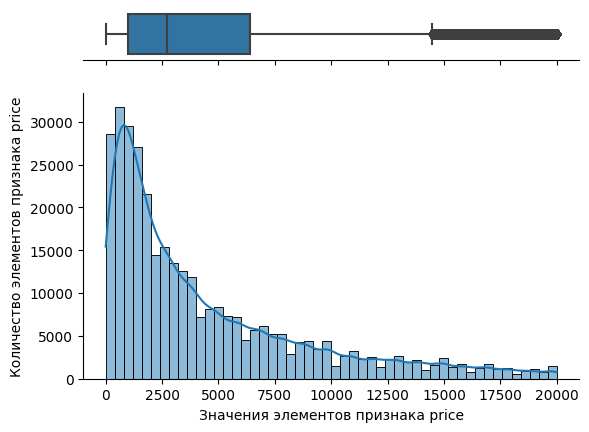

count    332341.000000
mean        110.265856
std         194.526379
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: power, dtype: float64


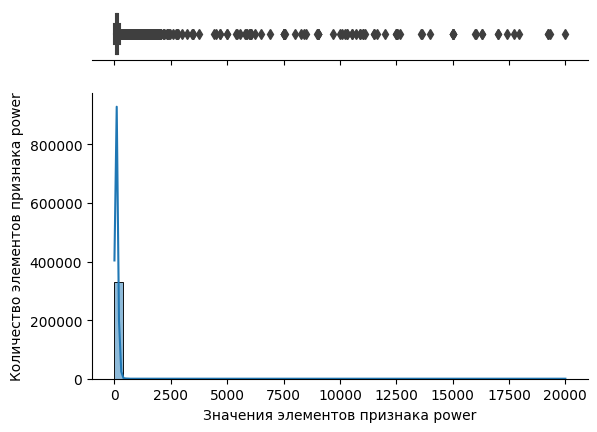

count    332341.000000
mean     127848.489955
std       38143.478951
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: kilometer, dtype: float64


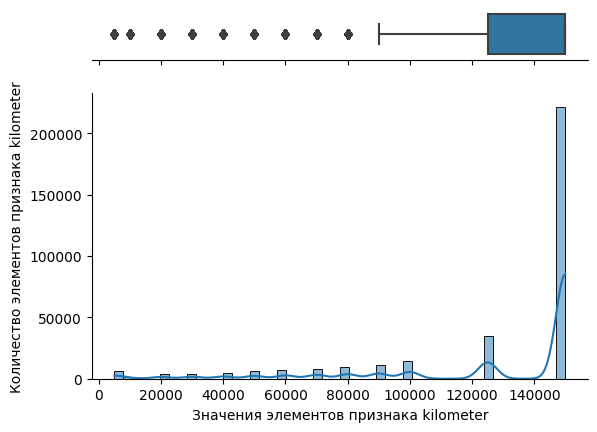

count    332341.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: number_of_pictures, dtype: float64


C:\Users\Maxim\anaconda3\envs\practicum\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


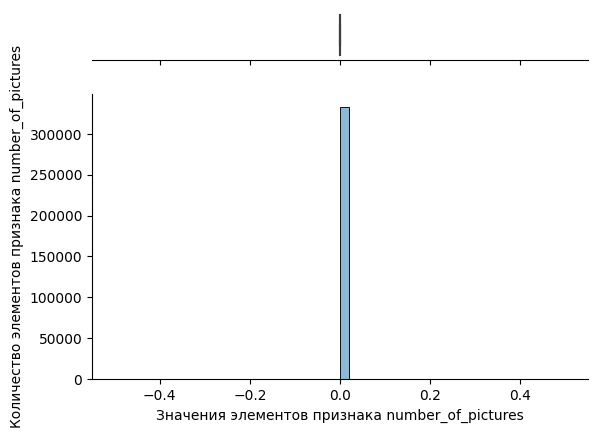

In [36]:
#year and month are categorial, postal code is non informative
print_hist_box(df.select_dtypes(include='number').drop(columns=['registration_year', 'registration_month', 'postal_code'])) 

- `price` - таргет имеет ненормальное распределение, попробуем прологарифмировать его, чтоб получить нормальное, потому что кто бы что не говорил, а в задачах регрессии лучше, чтобы таргет имел нормальное распределение

In [37]:
df[df['price'] < 500]

date_crawled  price vehicle_type  registration_year  gearbox  \
0      2016-03-24 11:52:17    480        sedan               1993   manual   
7      2016-03-21 18:54:38      0        sedan               1980   manual   
15     2016-03-11 21:39:15    450        small               1910  unknown   
16     2016-04-01 12:46:46    300        small               2016  unknown   
23     2016-03-12 19:43:07    450        small               1997   manual   
...                    ...    ...          ...                ...      ...   
332299 2016-03-15 19:57:11    400        wagon               1991   manual   
332308 2016-03-30 20:55:30    350        small               1996  unknown   
332314 2016-04-04 14:41:28    390        small               1997     auto   
332317 2016-03-31 19:52:33    180        sedan               1995  unknown   
332336 2016-03-21 09:50:58      0        sedan               2005   manual   

        power    model  kilometer  registration_month fuel_type       brand  \
0           0     golf     150000                   0    petrol  volkswagen   
7          50    other      40000                   7    petrol  volkswagen   
15          0       ka       5000                   0    petrol        ford   
16         60     polo     150000                   0    petrol  volkswagen   
23         50    arosa     150000                   5    petrol        seat   
...       ...      ...        ...                 ...       ...         ...   
332299      0   legacy     150000                   0    petrol      subaru   
332308     65    punto     150000                   0     other        fiat   
332314      0    corsa     100000                   6    petrol        opel   
332317      0  unknown     125000                   3    petrol        opel   
332336      0     colt     150000                   7    petrol  mitsubishi   

       repaired date_created  number_of_pictures  postal_code  \
0            no   2016-03-24                   0        70435   
7            no   2016-03-21                   0        19348   
15           no   2016-03-11                   0        24148   
16           no   2016-04-01                   0        38871   
23           no   2016-03-12                   0         9526   
...         ...          ...                 ...          ...   
332299       no   2016-03-15                   0        24558   
332308       no   2016-03-30                   0        25436   
332314      yes   2016-04-04                   0        17509   
332317       no   2016-03-31                   0        41470   
332336      yes   2016-03-21                   0         2694   

                 last_seen  
0      2016-04-07 03:16:57  
7      2016-03-25 16:47:58  
15     2016-03-19 08:46:47  
16     2016-04-01 12:46:46  
23     2016-03-21 01:46:11  
...                    ...  
332299 2016-03-19 15:49:00  
332308 2016-04-07 13:50:41  
332314 2016-04-06 15:46:11  
332317 2016-04-06 14:18:04  
332336 2016-03-21 10:42:49  

[34346 rows x 16 columns]

Тут придется удалить почти 17000 строк :( потому что как ни крути, а это либо объявления с ошибкой, либо как-то странно проданные автомобили, но восстановить цену точно не получится. Даже если это и реальные цены по каким то причинам, то эти причины в датасете, как правило не указаны, так что эти машины будут вносить сильный шум. А так как это таргет, то и экспериментировать со вставкой среднего вместо 0 и т.д. не стоит. Теряем примерно 3.5 % данных. То же самое можно сказть и про аномально высокие цены машины, но, просмотрев их, я увидел там бмв, форд мустанг и так далее. Иногда проскакивают конечно и выбросы, но все таки все машины с высокой ценой удалять думаю не стоит, несмотря на некоторые выбросы, хотя на 2016 год 20 000 евро это 1,5 млн. руб, так что их не трогаем

Машина за меньше, чем 100 евро тоже как-то странно, но мало ли, тут сложно сказть. Но все таки машины за 100 и даже за 10000 рублей - как правило - бред и, скорее всего ошибка - уберем их тоже. (за 100 евро даже сейчас можно что-то найти, но это что-то будет не на ходу))

In [38]:
df = df.drop(df[df['price'] < 500].index)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 297995 entries, 1 to 332340
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        297995 non-null  datetime64[ns]
 1   price               297995 non-null  int64         
 2   vehicle_type        297995 non-null  object        
 3   registration_year   297995 non-null  int64         
 4   gearbox             297995 non-null  object        
 5   power               297995 non-null  int64         
 6   model               297995 non-null  object        
 7   kilometer           297995 non-null  int64         
 8   registration_month  297995 non-null  int64         
 9   fuel_type           297995 non-null  object        
 10  brand               297995 non-null  object        
 11  repaired            297995 non-null  object        
 12  date_created        297995 non-null  datetime64[ns]
 13  number_of_pictures  297995 no

count    297995.000000
mean       4911.379016
std        4536.882289
min         500.000000
25%        1499.000000
50%        3200.000000
75%        6990.000000
max       20000.000000
Name: price, dtype: float64


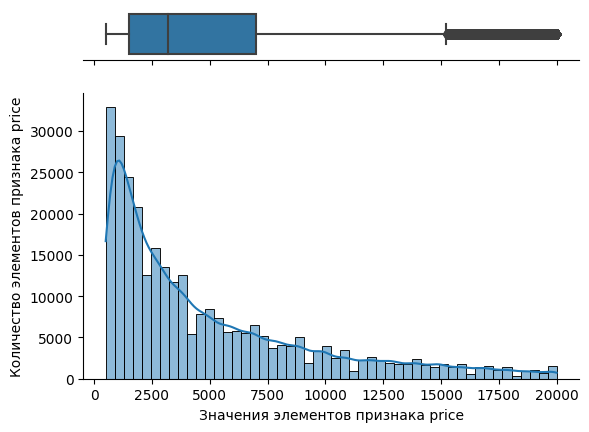

In [39]:
print_hist_box(df['price'].to_frame())

- `power` - мощность в л.с. Видны явные выбросы. Посмотрим на них

In [40]:
df[(df['power'] > 500) & (df['power'] < 1000)].head(10)

date_crawled  price vehicle_type  registration_year gearbox  \
4060  2016-04-03 20:31:00   3100        sedan               2005  manual   
6288  2016-03-31 23:50:47    599        small               2002  manual   
6494  2016-03-14 15:54:34   3000        small               2009  manual   
6626  2016-03-31 19:48:22    600        small               1996  manual   
8043  2016-03-15 13:49:25    500        small               2002  manual   
12709 2016-03-09 18:43:44   3500  convertible               2003  manual   
13339 2016-03-31 12:38:14  18500        small               2002    auto   
14514 2016-03-12 09:55:06    599        small               2018  manual   
17454 2016-03-23 18:59:00  15500        coupe               2009    auto   
20064 2016-03-21 10:37:15  18500          suv               2006    auto   

       power    model  kilometer  registration_month fuel_type       brand  \
4060     953     colt     150000                   4    petrol  mitsubishi   
6288     603    matiz       5000                  11    petrol   chevrolet   
6494     771    punto     125000                   0    petrol        fiat   
6626     603    corsa     150000                   8    petrol        opel   
8043     620  ypsilon     150000                  12    petrol      lancia   
12709    952       ka      70000                   5    petrol        ford   
13339    600   s_type     150000                  12     other      jaguar   
14514    599   twingo     150000                   0     other     renault   
17454    507  m_reihe     150000                   1    petrol         bmw   
20064    521  cayenne     150000                   5    petrol     porsche   

      repaired date_created  number_of_pictures  postal_code  \
4060        no   2016-04-03                   0        60326   
6288       yes   2016-03-31                   0        44379   
6494        no   2016-03-14                   0        40721   
6626       yes   2016-03-31                   0        70327   
8043        no   2016-03-15                   0        55566   
12709       no   2016-03-09                   0        26903   
13339       no   2016-03-31                   0        13595   
14514       no   2016-03-12                   0        47138   
17454      yes   2016-03-23                   0        74254   
20064       no   2016-03-21                   0        24939   

                last_seen  
4060  2016-04-07 14:56:46  
6288  2016-04-01 03:41:52  
6494  2016-03-14 15:54:34  
6626  2016-04-06 14:17:51  
8043  2016-04-06 03:15:27  
12709 2016-03-12 04:16:07  
13339 2016-04-06 04:46:34  
14514 2016-04-06 01:45:44  
17454 2016-03-31 07:44:43  
20064 2016-04-06 03:16:48

In [41]:
df[df['power'] > 10000].head(10)

date_crawled  price vehicle_type  registration_year gearbox  \
25095 2016-03-28 19:57:39  10900          bus               2009  manual   
44668 2016-04-07 07:36:38  15800  convertible               2014    auto   
56346 2016-04-01 21:55:58   1995        wagon               2002  manual   
62222 2016-03-27 18:47:59   2200        small               1999  manual   
63208 2016-03-28 11:49:56   3250        sedan               2001    auto   
76652 2016-03-25 13:36:57    850        sedan               2000  manual   
83447 2016-03-28 10:49:33   1999        sedan               1991    auto   
94615 2016-03-16 13:46:18   1380  convertible               2001    auto   
94825 2016-03-12 10:36:18   4700          bus               1997  manual   
96790 2016-03-31 18:54:51   5500        wagon               2010  manual   

       power        model  kilometer  registration_month fuel_type  \
25095  10520        caddy     150000                   6    petrol   
44668  10218       fortwo      30000                   3    petrol   
56346  11530        focus     150000                   1    petrol   
62222  12012         polo     150000                   3    petrol   
63208  17932        omega     150000                   6    petrol   
76652  12510        astra      30000                  10     other   
83447  10912      unknown     150000                   0    petrol   
94615  10710       megane     150000                  10     other   
94825  10522  transporter     150000                   0    petrol   
96790  11509         ceed     150000                   9     other   

               brand repaired date_created  number_of_pictures  postal_code  \
25095     volkswagen       no   2016-03-28                   0        36272   
44668          smart       no   2016-04-06                   0        81373   
56346           ford       no   2016-04-01                   0        35759   
62222     volkswagen       no   2016-03-27                   0         9526   
63208           opel       no   2016-03-28                   0        86641   
76652           opel       no   2016-03-25                   0        23611   
83447  mercedes_benz       no   2016-03-28                   0        88069   
94615        renault       no   2016-03-16                   0        71282   
94825     volkswagen       no   2016-03-12                   0        87437   
96790            kia       no   2016-03-31                   0        15907   

                last_seen  
25095 2016-04-07 02:47:02  
44668 2016-04-07 07:36:38  
56346 2016-04-05 14:44:36  
62222 2016-04-01 19:44:55  
63208 2016-04-06 14:17:21  
76652 2016-03-31 20:45:39  
83447 2016-03-30 01:15:32  
94615 2016-03-19 10:45:58  
94825 2016-03-12 10:36:18  
96790 2016-04-06 13:15:34

можем поправить выбросы сократив порядок больших, но некоторые модели и правда не являются выбросами - например порш кайен с 500+ л.с. вполне нормальная практика. Поэтому чтоб потерять минимум информации сначала заменим на таких выбивающихся моделях этот показатель на медианный по модели (среднее будет смещено как раз из-за выбросов) 

In [42]:
df.loc[df['power'] < 10, 'power'] = df.groupby('model')['power'].transform('median')
df[df['power'] < 10]

date_crawled  price vehicle_type  registration_year gearbox  \
224328 2016-03-30 11:39:08   3800        wagon               1978  manual   

        power    model  kilometer  registration_month fuel_type       brand  \
224328    0.0  serie_1      30000                   0    petrol  land_rover   

       repaired date_created  number_of_pictures  postal_code  \
224328       no   2016-03-30                   0        49824   

                 last_seen  
224328 2016-03-30 11:39:08

In [43]:
df.loc[df['power'] > 500, 'power'] = df.groupby('model')['power'].transform('median')
df[df['power'] > 500]

Empty DataFrame
Columns: [date_crawled, price, vehicle_type, registration_year, gearbox, power, model, kilometer, registration_month, fuel_type, brand, repaired, date_created, number_of_pictures, postal_code, last_seen]
Index: []

count    297995.000000
mean        121.239437
std          52.456168
min           0.000000
25%          82.000000
50%         113.000000
75%         150.000000
max         500.000000
Name: power, dtype: float64


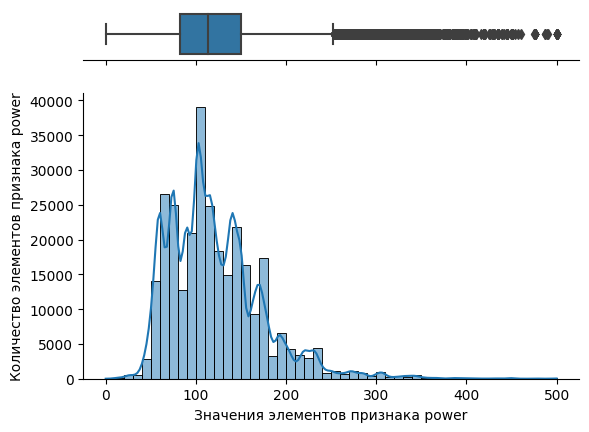

In [44]:
print_hist_box(df['power'].to_frame())

Видим опять много нулей. Машина не может быть без мощности, так что также заменим на среднее по модели

In [45]:
df.loc[df['power'] < 10].head(10)

date_crawled  price vehicle_type  registration_year gearbox  \
224328 2016-03-30 11:39:08   3800        wagon               1978  manual   

        power    model  kilometer  registration_month fuel_type       brand  \
224328    0.0  serie_1      30000                   0    petrol  land_rover   

       repaired date_created  number_of_pictures  postal_code  \
224328       no   2016-03-30                   0        49824   

                 last_seen  
224328 2016-03-30 11:39:08

In [46]:
# df.loc[df['power'] < 10, 'power'] = df.groupby('model')['power'].transform('median')
df = df.drop(df[df['power'] < 10].index)
df[df['power'] < 10]

Empty DataFrame
Columns: [date_crawled, price, vehicle_type, registration_year, gearbox, power, model, kilometer, registration_month, fuel_type, brand, repaired, date_created, number_of_pictures, postal_code, last_seen]
Index: []

count    297994.000000
mean        121.239844
std          52.455786
min          10.000000
25%          82.000000
50%         113.000000
75%         150.000000
max         500.000000
Name: power, dtype: float64


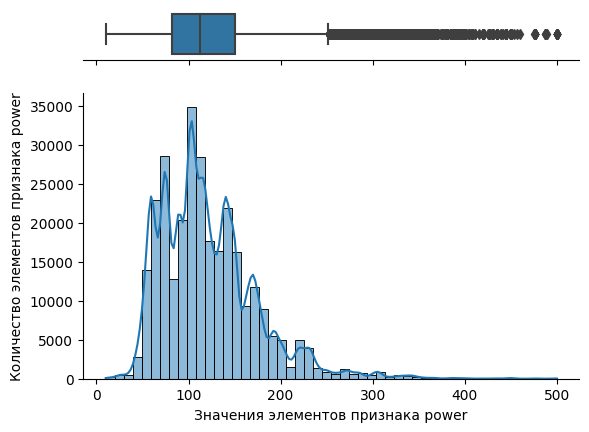

In [47]:
print_hist_box(df['power'].to_frame())

Оставшиеся выбросы не являются аномалиями, так что оставить можно

- `kilometer` - пробег - распределение не являтся нормальным, причем больше, чем у половины машин пробег строго равен 150 000. В целом действительности может соответствовать, но значение, по-видимому, округленное. Выбросы аномалиями не являются, так что оставляем

И ни для одной машины не указыно ни одной фотографии, так что этот признак можно убать, полную работу с фичами произведем на 3 шаге

In [48]:
df.head()

date_crawled  price vehicle_type  registration_year gearbox  power  \
1 2016-03-24 10:58:45  18300        coupe               2011  manual  190.0   
2 2016-03-14 12:52:21   9800          suv               2004    auto  163.0   
3 2016-03-17 16:54:04   1500        small               2001  manual   75.0   
4 2016-03-31 17:25:20   3600        small               2008  manual   69.0   
5 2016-04-04 17:36:23    650        sedan               1995  manual  102.0   

     model  kilometer  registration_month fuel_type       brand repaired  \
1  unknown     125000                   5    petrol        audi      yes   
2    grand     125000                   8    petrol        jeep       no   
3     golf     150000                   6    petrol  volkswagen       no   
4    fabia      90000                   7    petrol       skoda       no   
5      3er     150000                  10    petrol         bmw      yes   

  date_created  number_of_pictures  postal_code           last_seen  
1   2016-03-24                   0        66954 2016-04-07 01:46:50  
2   2016-03-14                   0        90480 2016-04-05 12:47:46  
3   2016-03-17                   0        91074 2016-03-17 17:40:17  
4   2016-03-31                   0        60437 2016-04-06 10:17:21  
5   2016-04-04                   0        33775 2016-04-06 19:17:07

Посмотрим на даты публикации объявлений. Это нам нужно для последющего анализа

In [49]:
sorted(df['date_created'].unique())

[numpy.datetime64('2014-03-10T00:00:00.000000000'),
 numpy.datetime64('2015-03-20T00:00:00.000000000'),
 numpy.datetime64('2015-06-18T00:00:00.000000000'),
 numpy.datetime64('2015-08-07T00:00:00.000000000'),
 numpy.datetime64('2015-08-10T00:00:00.000000000'),
 numpy.datetime64('2015-09-04T00:00:00.000000000'),
 numpy.datetime64('2015-09-09T00:00:00.000000000'),
 numpy.datetime64('2015-11-02T00:00:00.000000000'),
 numpy.datetime64('2015-11-08T00:00:00.000000000'),
 numpy.datetime64('2015-11-10T00:00:00.000000000'),
 numpy.datetime64('2015-11-12T00:00:00.000000000'),
 numpy.datetime64('2015-11-17T00:00:00.000000000'),
 numpy.datetime64('2015-11-23T00:00:00.000000000'),
 numpy.datetime64('2015-11-24T00:00:00.000000000'),
 numpy.datetime64('2015-12-05T00:00:00.000000000'),
 numpy.datetime64('2015-12-06T00:00:00.000000000'),
 numpy.datetime64('2015-12-17T00:00:00.000000000'),
 numpy.datetime64('2015-12-27T00:00:00.000000000'),
 numpy.datetime64('2015-12-30T00:00:00.000000000'),
 numpy.datet

видим объявления с марта 2014 по апрель 2016

count     297994
unique         8
top        sedan
freq       93668
Name: vehicle_type, dtype: object


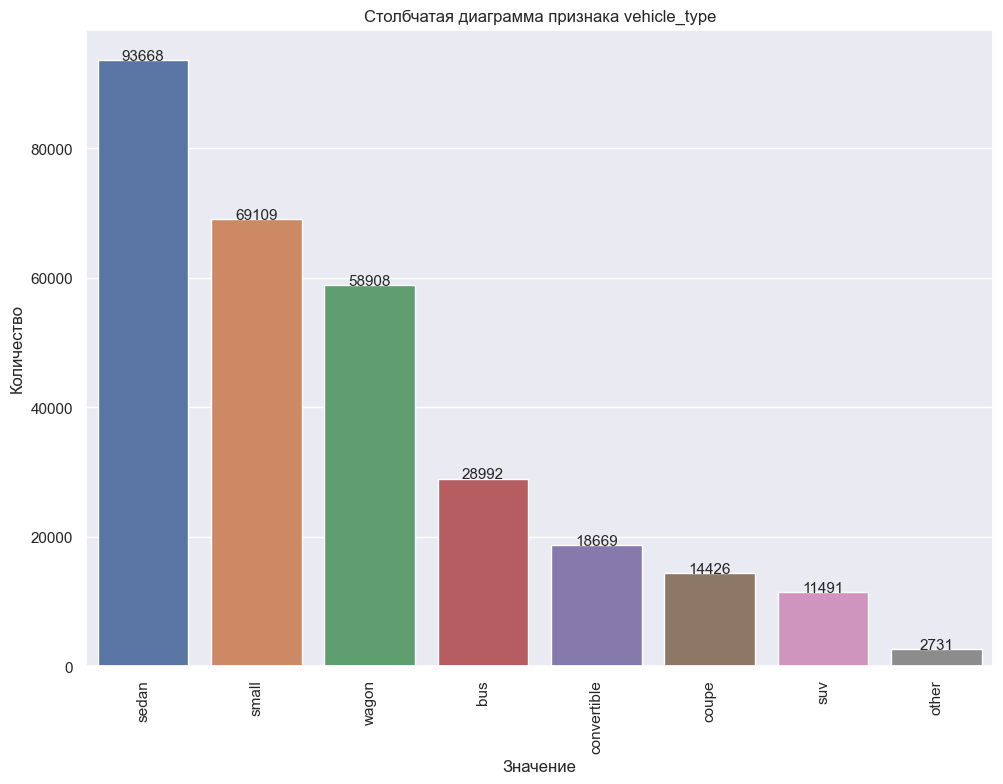

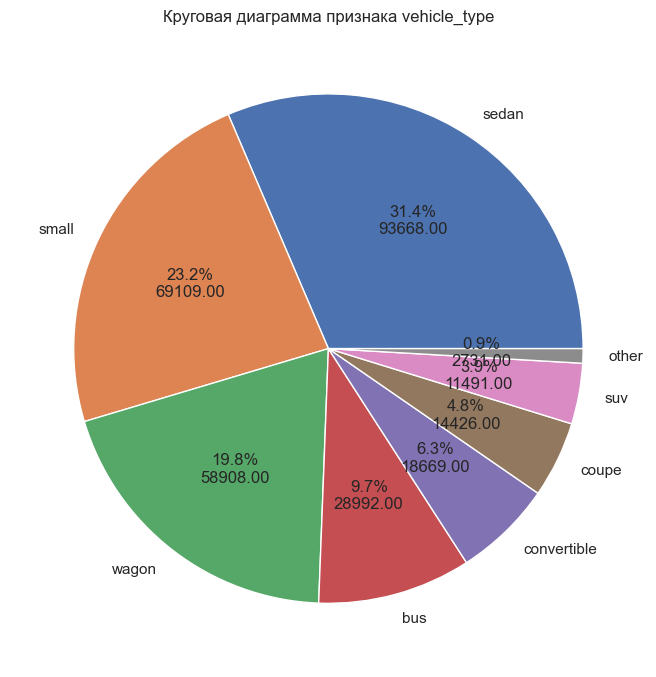

count    297994.000000
mean       2004.196897
std          66.772381
min        1000.000000
25%        1999.000000
50%        2004.000000
75%        2008.000000
max        9999.000000
Name: registration_year, dtype: float64


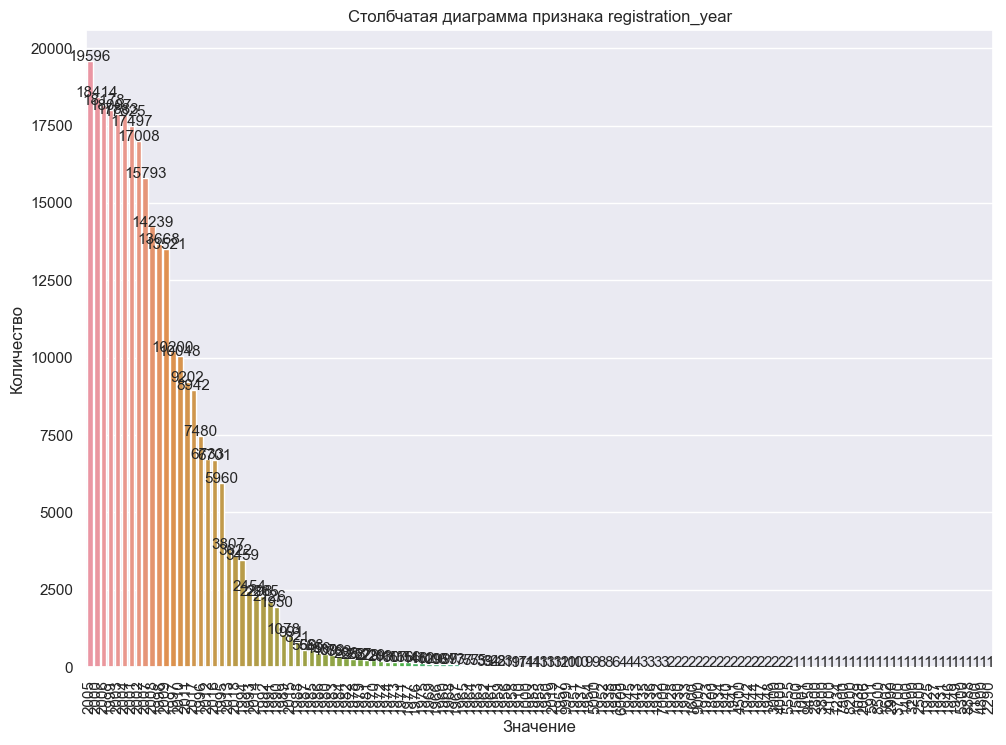

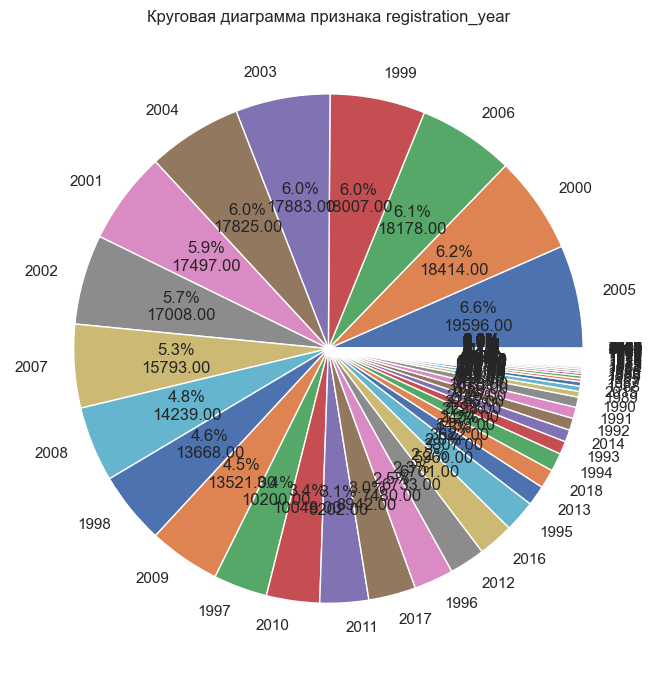

count     297994
unique         3
top       manual
freq      225726
Name: gearbox, dtype: object


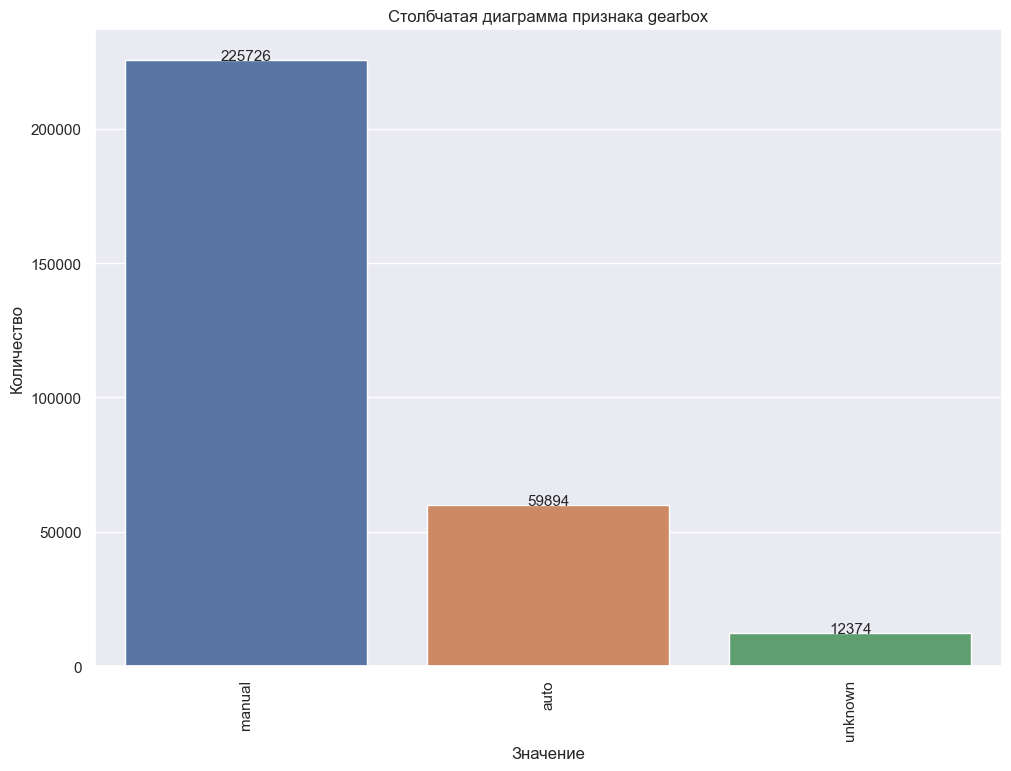

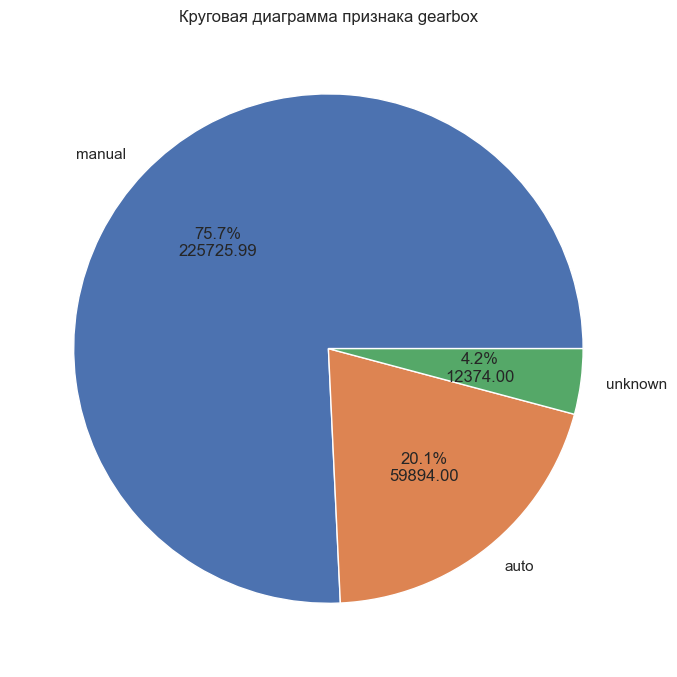

count     297994
unique       249
top         golf
freq       23715
Name: model, dtype: object


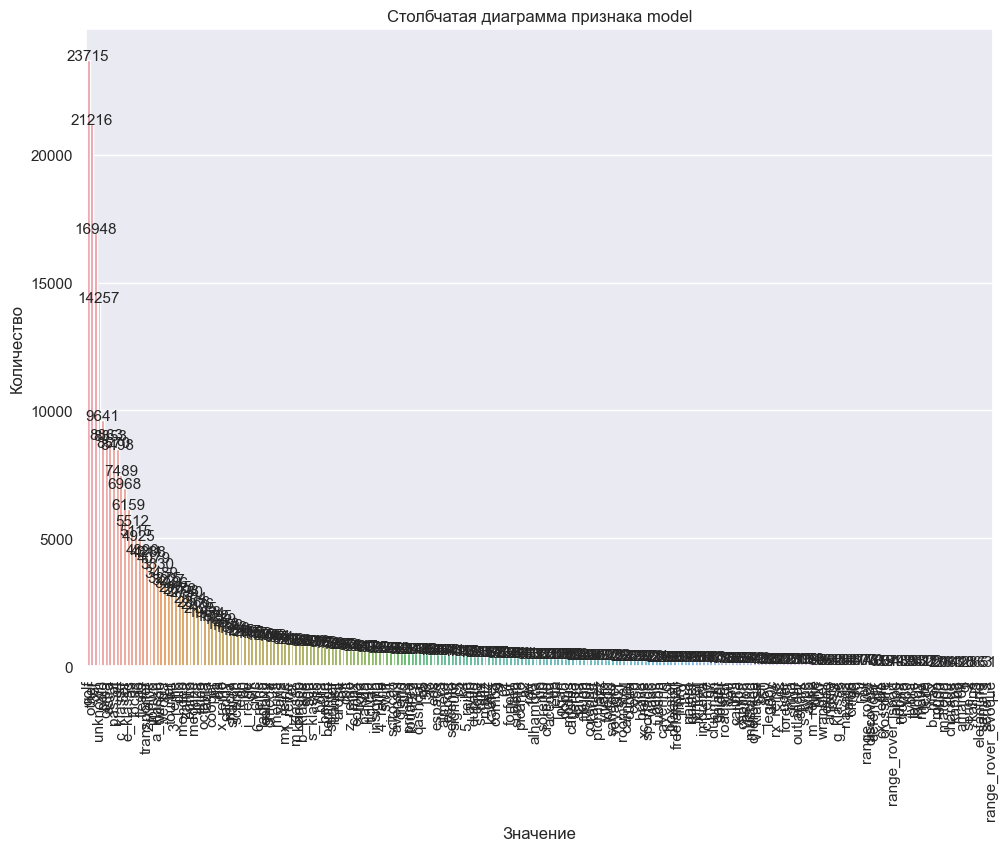

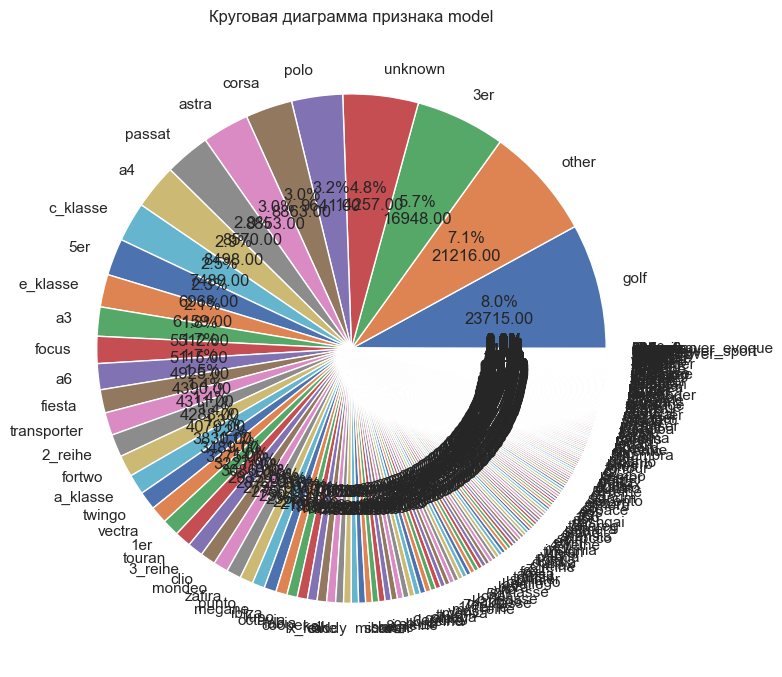

count    297994.000000
mean          5.895877
std           3.649418
min           0.000000
25%           3.000000
50%           6.000000
75%           9.000000
max          12.000000
Name: registration_month, dtype: float64


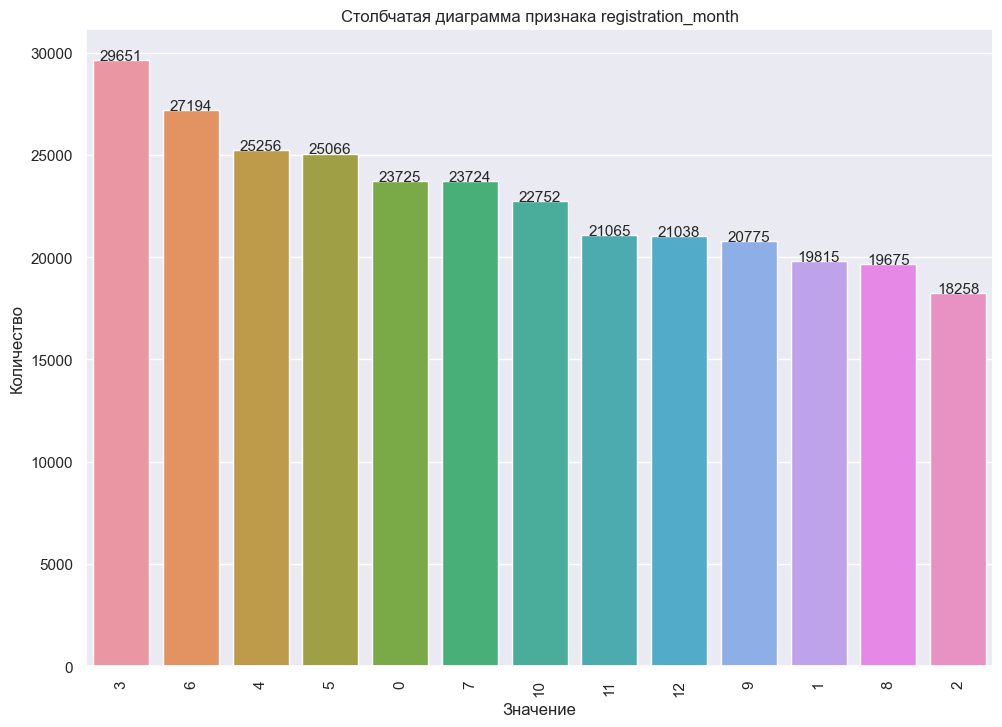

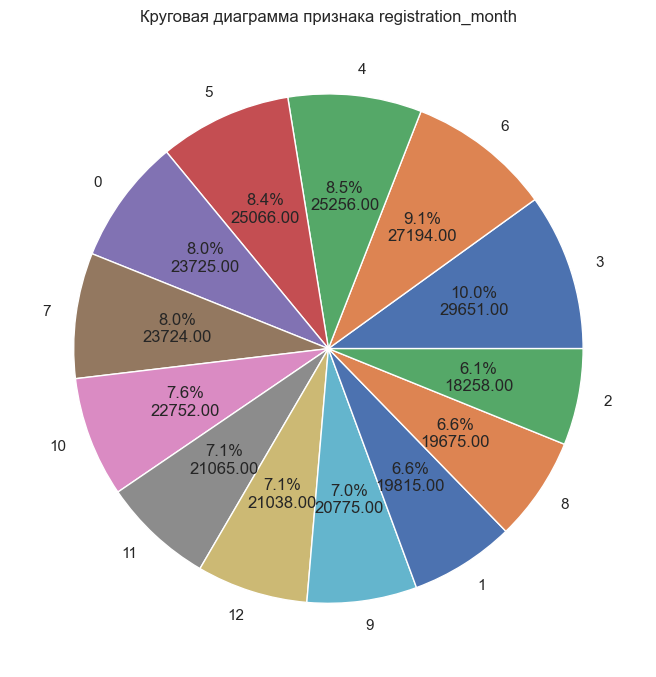

count     297994
unique         6
top       petrol
freq      269623
Name: fuel_type, dtype: object


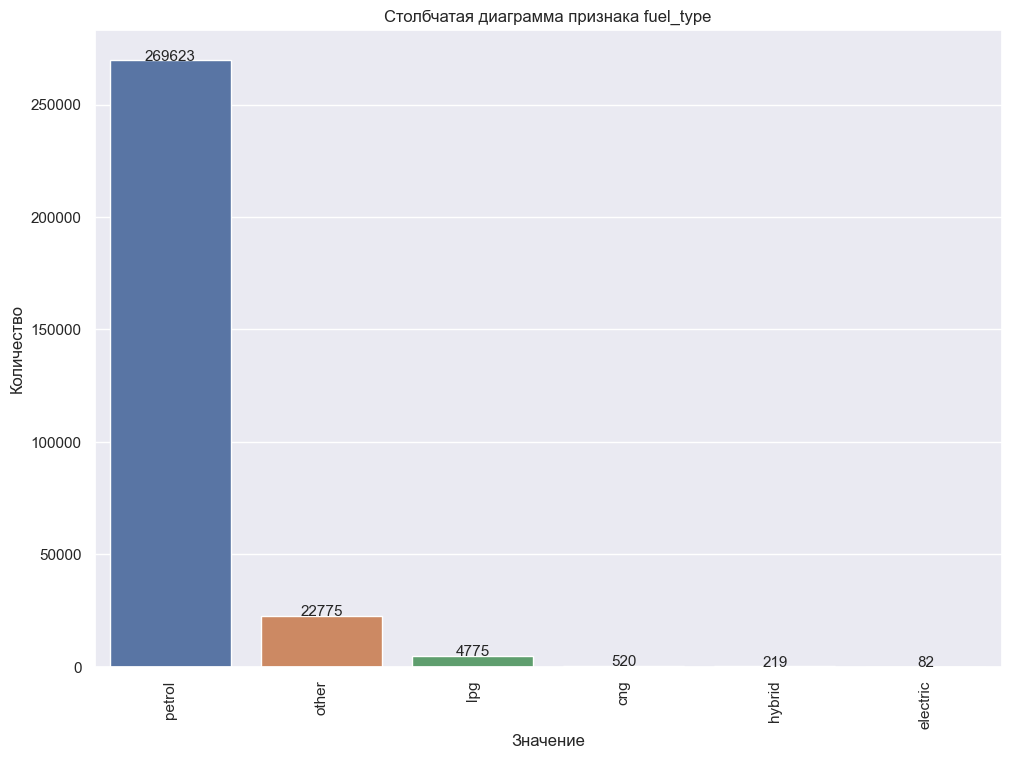

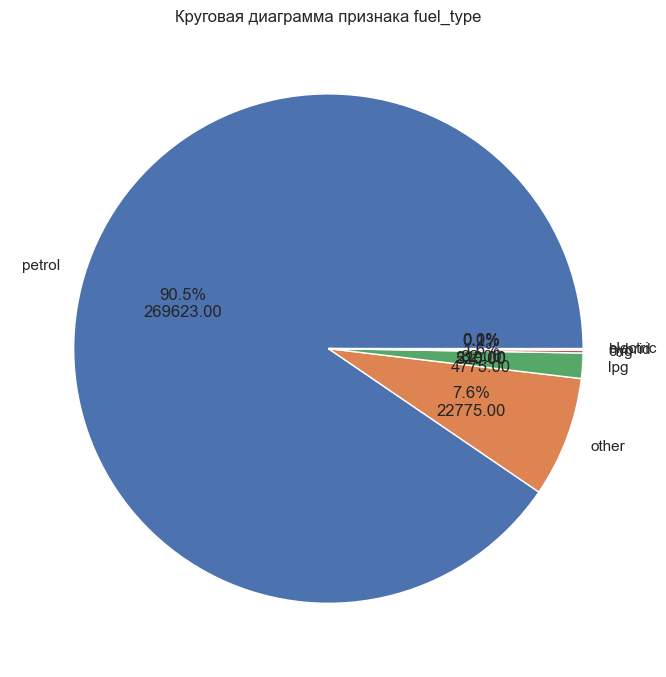

count         297994
unique            40
top       volkswagen
freq           63177
Name: brand, dtype: object


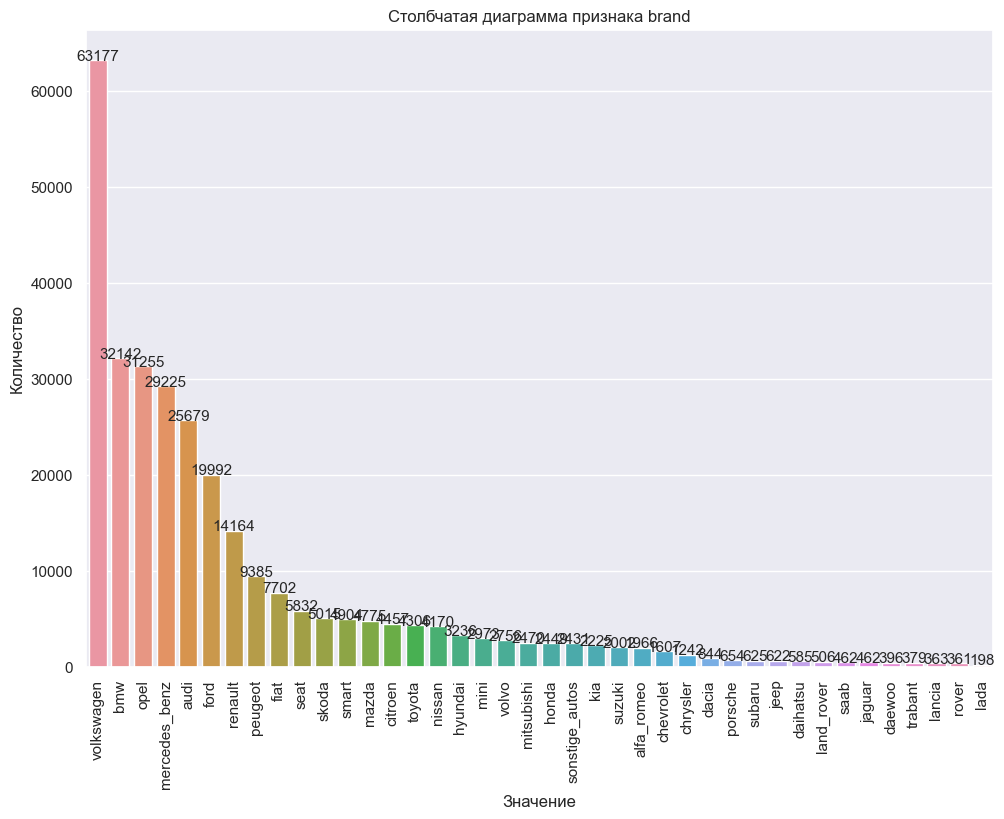

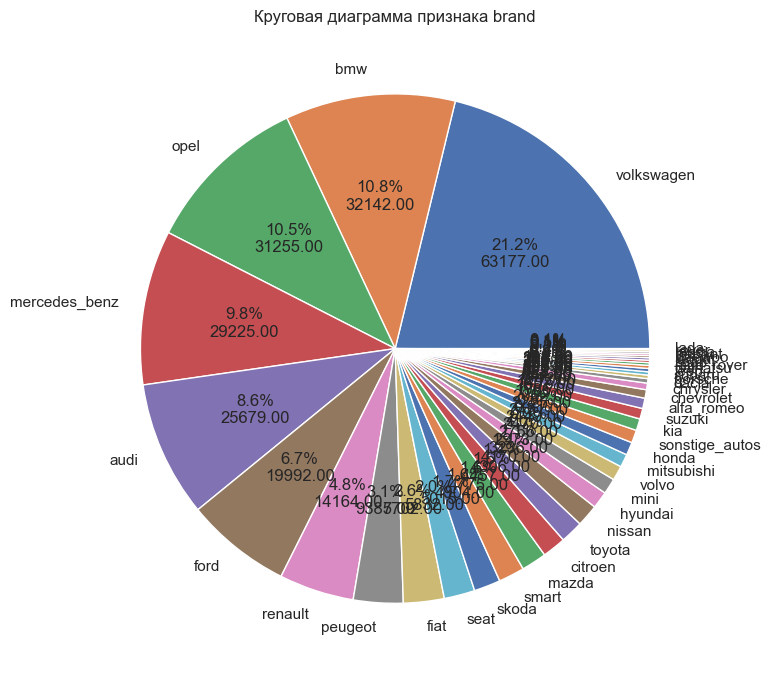

count     297994
unique         2
top           no
freq      272443
Name: repaired, dtype: object


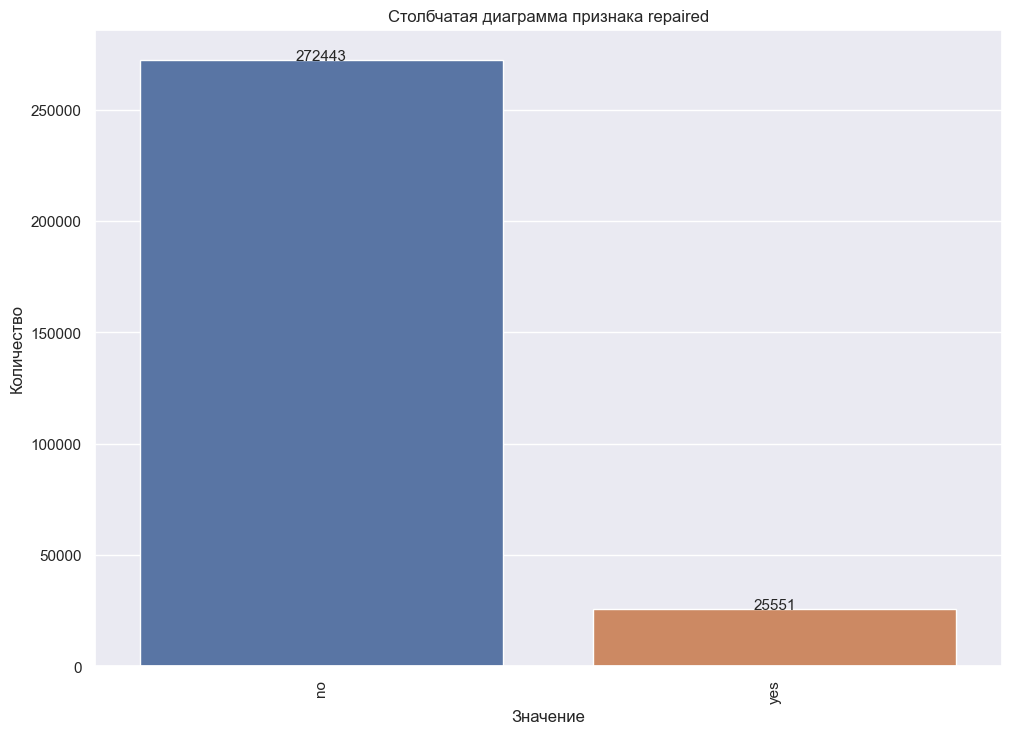

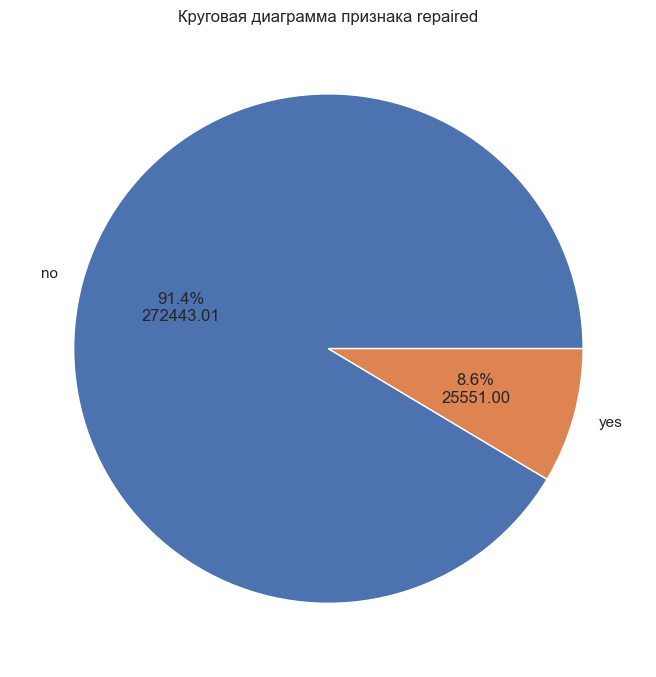

In [50]:
print_pie_bar(df[['vehicle_type', 'registration_year', 'gearbox', 'model', 'registration_month', 'fuel_type', 'brand', 'repaired']])

Интересная картина в некоторых местах. Пойдем разбираться по одному:
- с типом кузова все хорошо, сюрпризов нет

Далее год регистрации - насколько я понимаю, год регистрации (и месяц) не может быть больше года и месяца даты публикации, потому что мы же не можем продавать машину, которую зарегистрировали в будующем - поэтому сменим для таких автомобилей год и месяц на дату публикации (может какие-то перекупы, сегодня купили, помыли, и тут же перепродают)=)

In [51]:
df[df['registration_year'] > 2016]

date_crawled  price vehicle_type  registration_year  gearbox  \
22     2016-03-23 14:52:51   2900          bus               2018   manual   
26     2016-03-10 19:38:18   5555        sedan               2017   manual   
48     2016-03-25 14:40:12   7750        sedan               2017   manual   
51     2016-03-07 18:57:08   2000        small               2017   manual   
57     2016-03-10 20:53:19   2399        sedan               2018   manual   
...                    ...    ...          ...                ...      ...   
332124 2016-03-11 15:49:51   3600          bus               2017   manual   
332150 2016-03-29 16:47:29   1000        wagon               2017   manual   
332201 2016-03-17 00:56:26   2140        small               2018   manual   
332246 2016-03-25 09:37:59   1250        small               2018  unknown   
332275 2016-03-05 14:55:29   5000        sedan               2017   manual   

        power    model  kilometer  registration_month fuel_type       brand  \
22       90.0   meriva     150000                   5    petrol        opel   
26      125.0       c4     125000                   4     other     citroen   
48       80.0     golf     100000                   1    petrol  volkswagen   
51       90.0    punto     150000                  11    petrol        fiat   
57       64.0    other     125000                   3     other        seat   
...       ...      ...        ...                 ...       ...         ...   
332124   86.0  transit     150000                   5    petrol        ford   
332150  101.0       a4     150000                   9     other        audi   
332201   80.0   fiesta     150000                   6     other        ford   
332246   60.0    corsa     150000                   0    petrol        opel   
332275  120.0    other     150000                   7     other     citroen   

       repaired date_created  number_of_pictures  postal_code  \
22           no   2016-03-23                   0        49716   
26           no   2016-03-10                   0        31139   
48           no   2016-03-25                   0        48499   
51          yes   2016-03-07                   0        66115   
57           no   2016-03-10                   0        33397   
...         ...          ...                 ...          ...   
332124       no   2016-03-11                   0        32339   
332150       no   2016-03-29                   0        38315   
332201       no   2016-03-17                   0        44866   
332246       no   2016-03-25                   0        45527   
332275      yes   2016-03-05                   0        15518   

                 last_seen  
22     2016-03-31 01:16:33  
26     2016-03-16 09:16:46  
48     2016-03-31 21:47:44  
51     2016-03-07 18:57:08  
57     2016-03-25 10:17:37  
...                    ...  
332124 2016-03-12 05:45:02  
332150 2016-04-06 02:44:27  
332201 2016-03-29 15:45:04  
332246 2016-04-06 07:46:13  
332275 2016-04-05 11:48:09  

[12631 rows x 16 columns]

In [52]:
df['registration_year'] = df.apply(lambda x: x['date_created'].year 
                                       if x['registration_year'] > x['date_created'].year
                                       else x['registration_year'], axis=1)
df[df['registration_year'] > df['date_created'].dt.year]

Empty DataFrame
Columns: [date_crawled, price, vehicle_type, registration_year, gearbox, power, model, kilometer, registration_month, fuel_type, brand, repaired, date_created, number_of_pictures, postal_code, last_seen]
Index: []

In [53]:
df[df['registration_year'] < 1960]

date_crawled  price vehicle_type  registration_year  gearbox  \
1928   2016-03-25 15:58:21   7000          suv               1945   manual   
2273   2016-03-15 21:44:32   1800  convertible               1925  unknown   
3333   2016-03-15 21:36:20  10500        sedan               1955   manual   
10162  2016-03-27 13:59:08   1250        sedan               1910  unknown   
12961  2016-03-07 14:38:00  11000        other               1955   manual   
...                    ...    ...          ...                ...      ...   
329529 2016-03-27 20:45:09  17500        sedan               1954   manual   
329627 2016-03-09 21:56:01   5500          bus               1956   manual   
329967 2016-03-12 00:57:39  11500        sedan               1800  unknown   
331605 2016-03-16 21:56:55   6000        sedan               1937   manual   
332298 2016-03-07 19:58:44   3300        coupe               1957   manual   

        power    model  kilometer  registration_month fuel_type  \
1928     48.0    other     150000                   2    petrol   
2273     90.0  unknown       5000                   1     other   
3333     30.0    other      60000                   0    petrol   
10162   113.0    other       5000                   0     other   
12961    40.0  unknown      50000                   1    petrol   
...       ...      ...        ...                 ...       ...   
329529   52.0    other      20000                   7    petrol   
329627   37.0  unknown      60000                   4    petrol   
329967   16.0    other       5000                   6    petrol   
331605   38.0    other       5000                   0    petrol   
332298   40.0    other     100000                  11    petrol   

                 brand repaired date_created  number_of_pictures  postal_code  \
1928        volkswagen       no   2016-03-25                   0        58135   
2273    sonstige_autos       no   2016-03-15                   0        79288   
3333              ford       no   2016-03-15                   0        53498   
10162             audi       no   2016-03-27                   0        18445   
12961   sonstige_autos       no   2016-03-07                   0        59556   
...                ...      ...          ...                 ...          ...   
329529         citroen       no   2016-03-27                   0        55270   
329627  sonstige_autos       no   2016-03-09                   0         1900   
329967            fiat       no   2016-03-11                   0        16515   
331605   mercedes_benz       no   2016-03-16                   0        23936   
332298         trabant       no   2016-03-07                   0        10317   

                 last_seen  
1928   2016-03-25 15:58:21  
2273   2016-04-07 05:15:34  
3333   2016-04-07 08:16:11  
10162  2016-04-07 10:45:31  
12961  2016-03-14 06:44:36  
...                    ...  
329529 2016-04-05 18:47:03  
329627 2016-04-06 02:17:54  
329967 2016-04-05 19:47:27  
331605 2016-03-30 18:47:41  
332298 2016-03-08 06:45:48  

[258 rows x 16 columns]

И откинем соответственно совсем древние автомобили, а вернее ошибочно древние, 300 строк - просто удалим

In [54]:
df = df.drop(df[df['registration_year'] < 1960].index)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 297736 entries, 1 to 332340
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        297736 non-null  datetime64[ns]
 1   price               297736 non-null  int64         
 2   vehicle_type        297736 non-null  object        
 3   registration_year   297736 non-null  int64         
 4   gearbox             297736 non-null  object        
 5   power               297736 non-null  float64       
 6   model               297736 non-null  object        
 7   kilometer           297736 non-null  int64         
 8   registration_month  297736 non-null  int64         
 9   fuel_type           297736 non-null  object        
 10  brand               297736 non-null  object        
 11  repaired            297736 non-null  object        
 12  date_created        297736 non-null  datetime64[ns]
 13  number_of_pictures  297736 no

Проделаем то же самое теперь по месяцам

In [55]:
df[(df['registration_year'] == df['date_created'].dt.year) & (df['date_created'].dt.month < df['registration_month'])]

date_crawled  price vehicle_type  registration_year gearbox  \
22     2016-03-23 14:52:51   2900          bus               2016  manual   
26     2016-03-10 19:38:18   5555        sedan               2016  manual   
31     2016-03-29 16:57:02    899        small               2016  manual   
51     2016-03-07 18:57:08   2000        small               2016  manual   
155    2016-03-09 12:53:53  14500          suv               2016  manual   
...                    ...    ...          ...                ...     ...   
332172 2016-03-29 19:50:03   3000        sedan               2016  manual   
332197 2016-03-10 23:36:19   1350        coupe               2016  manual   
332201 2016-03-17 00:56:26   2140        small               2016  manual   
332275 2016-03-05 14:55:29   5000        sedan               2016  manual   
332334 2016-03-09 13:37:43   5250        wagon               2016    auto   

        power     model  kilometer  registration_month fuel_type  \
22       90.0    meriva     150000                   5    petrol   
26      125.0        c4     125000                   4     other   
31       60.0      clio     150000                   6    petrol   
51       90.0     punto     150000                  11    petrol   
155     136.0  sportage     125000                   5    petrol   
...       ...       ...        ...                 ...       ...   
332172   82.0      colt     150000                   8    petrol   
332197  184.0       clk     150000                   8     other   
332201   80.0    fiesta     150000                   6     other   
332275  120.0     other     150000                   7     other   
332334  150.0       159     150000                  12     other   

                brand repaired date_created  number_of_pictures  postal_code  \
22               opel       no   2016-03-23                   0        49716   
26            citroen       no   2016-03-10                   0        31139   
31            renault       no   2016-03-29                   0        37075   
51               fiat      yes   2016-03-07                   0        66115   
155               kia       no   2016-03-09                   0        49696   
...               ...      ...          ...                 ...          ...   
332172     mitsubishi       no   2016-03-29                   0        45472   
332197  mercedes_benz      yes   2016-03-10                   0        26427   
332201           ford       no   2016-03-17                   0        44866   
332275        citroen      yes   2016-03-05                   0        15518   
332334     alfa_romeo       no   2016-03-09                   0        51371   

                 last_seen  
22     2016-03-31 01:16:33  
26     2016-03-16 09:16:46  
31     2016-03-29 17:43:07  
51     2016-03-07 18:57:08  
155    2016-04-05 23:45:15  
...                    ...  
332172 2016-04-06 05:46:43  
332197 2016-03-13 02:45:51  
332201 2016-03-29 15:45:04  
332275 2016-04-05 11:48:09  
332334 2016-03-13 01:44:13  

[11166 rows x 16 columns]

In [56]:
df['registration_month'] = df.apply(lambda x: x['date_created'].month 
                                       if x['registration_month'] > x['date_created'].month
                                       else x['registration_month'], axis=1)
df[df['registration_month'] > df['date_created'].dt.month]

Empty DataFrame
Columns: [date_crawled, price, vehicle_type, registration_year, gearbox, power, model, kilometer, registration_month, fuel_type, brand, repaired, date_created, number_of_pictures, postal_code, last_seen]
Index: []

count    297736.000000
mean       2003.492309
std           7.007778
min        1960.000000
25%        1999.000000
50%        2004.000000
75%        2008.000000
max        2016.000000
Name: registration_year, dtype: float64


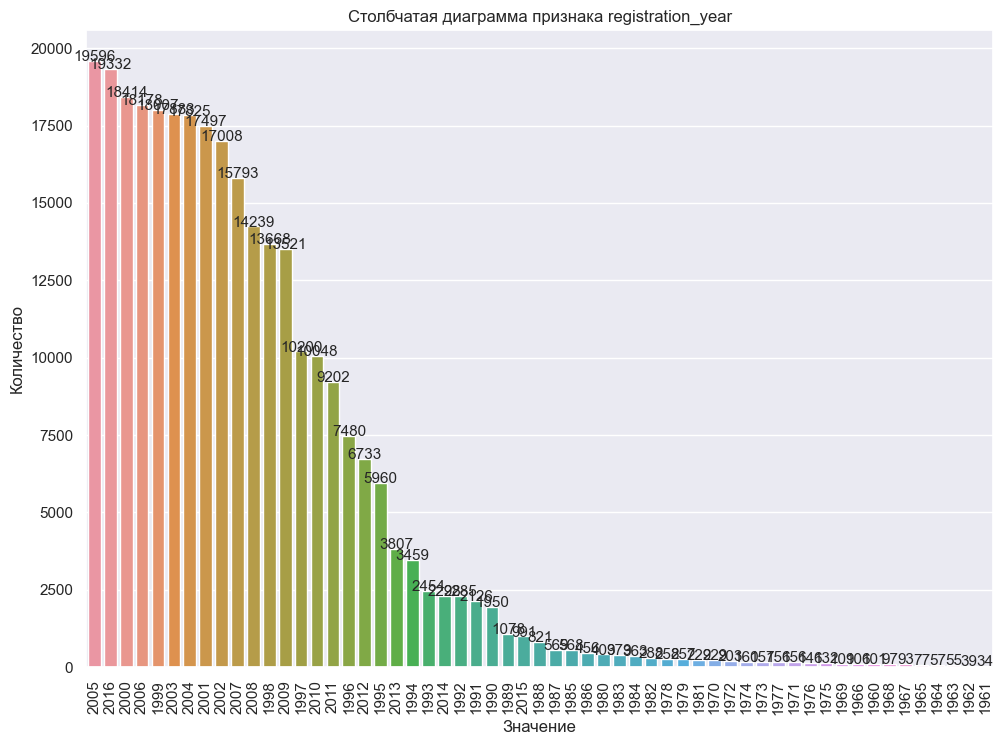

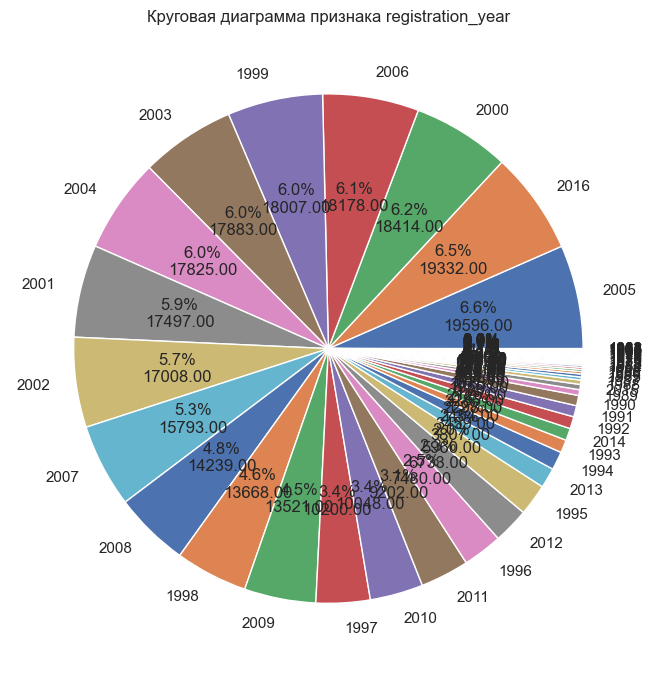

In [57]:
print_pie_bar(df['registration_year'].to_frame())

Чуть перестроим пайплот:

count     297736
unique        18
top          old
freq       75371
Name: registration_year, dtype: object


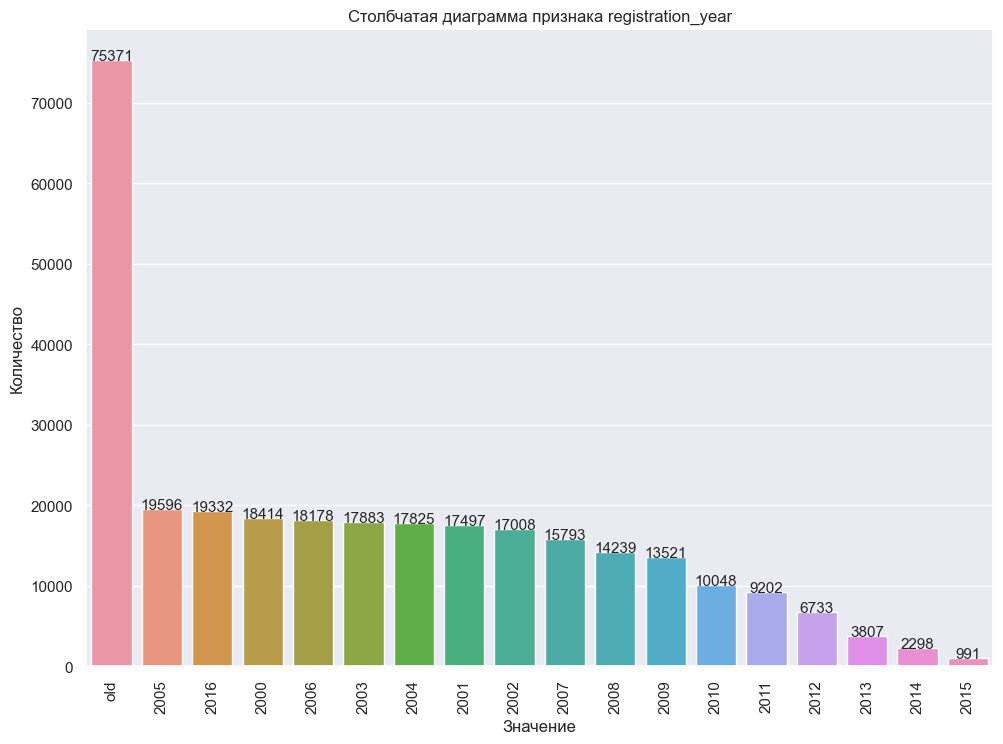

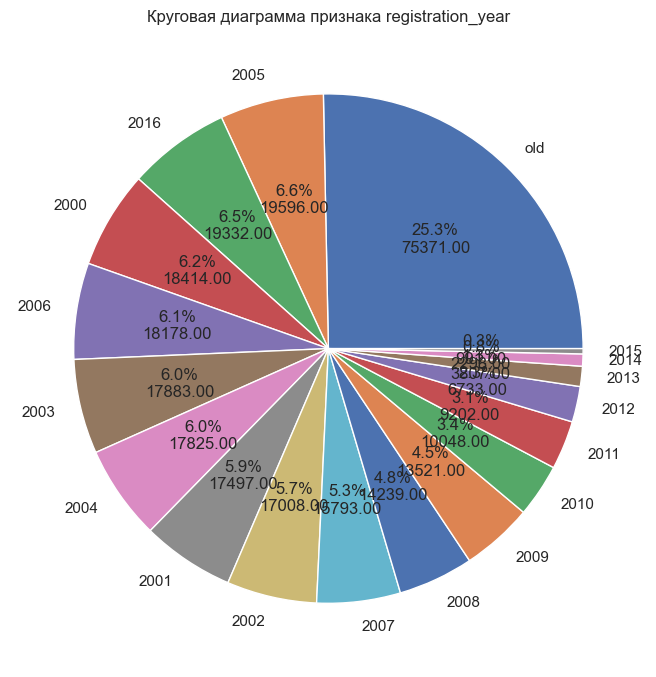

In [58]:
tmp = df['registration_year'].apply(lambda x: 'old' if x < 2000 else x)
print_pie_bar(tmp.to_frame())

На рынке представлено порядка 28% старых автомобилей, что ожидаемо. Объединение можно было бы не делать, но так читаемее

По моделям нет смысла что-то перестраивать, если только взять и построить топ 10 продаваемых моделей

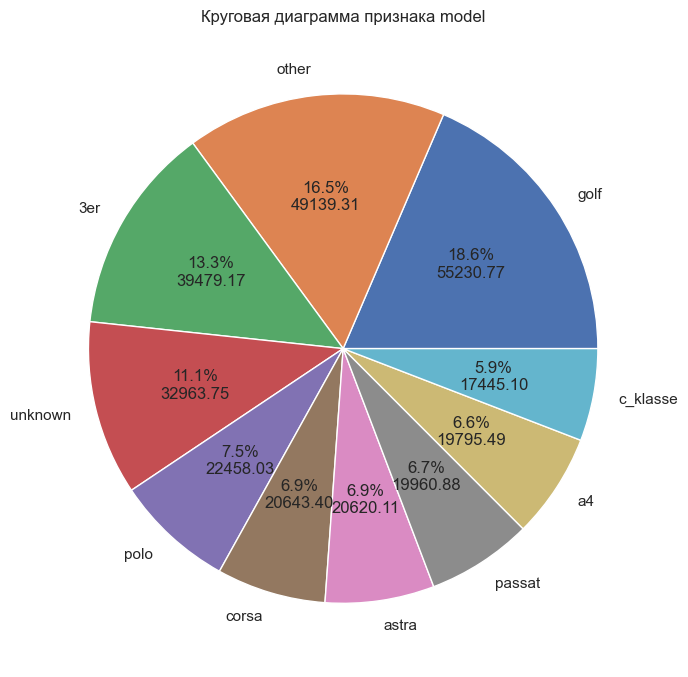

In [59]:
total = df['model'].count()
df['model'].value_counts().head(10).plot(kind='pie', autopct=fmt)
plt.title('Круговая диаграмма признака model')
plt.ylabel('')
plt.show()

- тип топлива - `fuel_type` все нормально, без неожиданностей - в основном бензин или газ
- тип коробки передач тоже без сюрпризов - в основном на механике
- по брендам тоже, но явный лидер рынка - фольцваген
- основная часть машин в ремонте не была
- присутствует нулевой месяц, что странно, скорее всего это заглушка на случай отстутсвия месяца в объявлении оставим пока так

Я постарался сохранить максимальное количество данных с минимальными искажениями... Надеюсь получилось)

### Корреляционный анализ данных

Распределения признаков нормальным не является, так что сразу построим `Фk`

In [60]:
df.head()

date_crawled  price vehicle_type  registration_year gearbox  power  \
1 2016-03-24 10:58:45  18300        coupe               2011  manual  190.0   
2 2016-03-14 12:52:21   9800          suv               2004    auto  163.0   
3 2016-03-17 16:54:04   1500        small               2001  manual   75.0   
4 2016-03-31 17:25:20   3600        small               2008  manual   69.0   
5 2016-04-04 17:36:23    650        sedan               1995  manual  102.0   

     model  kilometer  registration_month fuel_type       brand repaired  \
1  unknown     125000                   3    petrol        audi      yes   
2    grand     125000                   3    petrol        jeep       no   
3     golf     150000                   3    petrol  volkswagen       no   
4    fabia      90000                   3    petrol       skoda       no   
5      3er     150000                   4    petrol         bmw      yes   

  date_created  number_of_pictures  postal_code           last_seen  
1   2016-03-24                   0        66954 2016-04-07 01:46:50  
2   2016-03-14                   0        90480 2016-04-05 12:47:46  
3   2016-03-17                   0        91074 2016-03-17 17:40:17  
4   2016-03-31                   0        60437 2016-04-06 10:17:21  
5   2016-04-04                   0        33775 2016-04-06 19:17:07

In [61]:
interval_columns = df.select_dtypes(include='number').drop(columns=['registration_year', 'registration_month', 'postal_code', 'kilometer']).columns

C:\Users\Maxim\anaconda3\envs\practicum\lib\site-packages\phik\data_quality.py:72: UserWarning: Not enough unique value for variable number_of_pictures for analysis 1. Dropping this column
  warnings.warn(


Text(0.5, 1.0, 'корреляция $\\phi_K$')

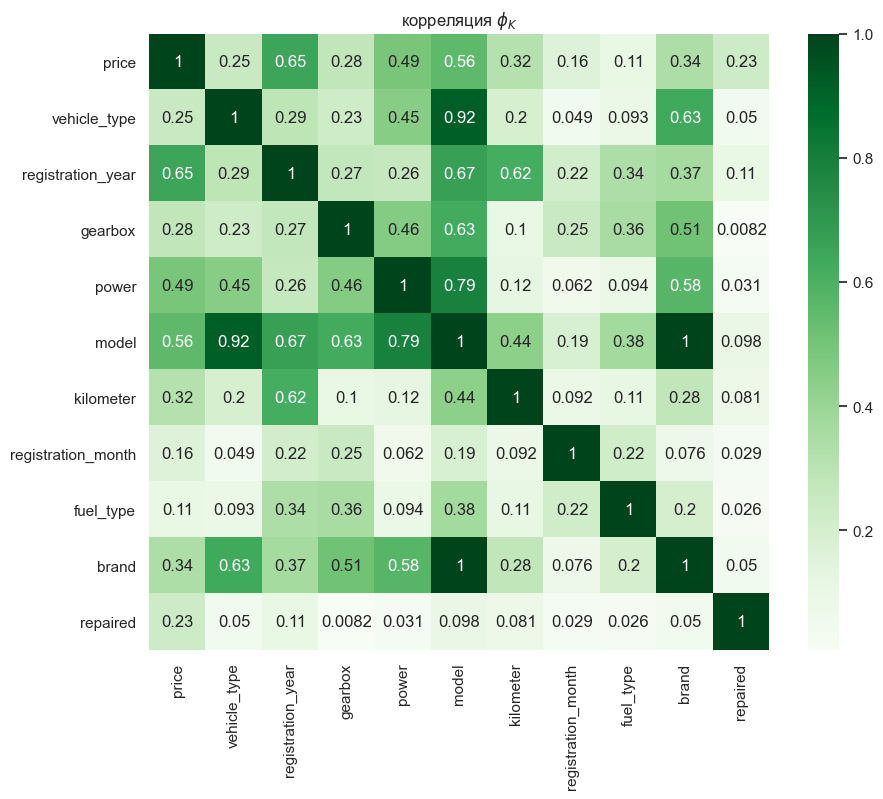

In [62]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.drop(columns=['date_crawled', 'last_seen', 'postal_code', 'date_created']).phik_matrix(interval_cols=interval_columns), annot=True, cmap='Greens')
plt.title(r'корреляция $\phi_K$')

In [63]:
# df = df.drop(columns=['vehicle_type'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 297736 entries, 1 to 332340
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        297736 non-null  datetime64[ns]
 1   price               297736 non-null  int64         
 2   vehicle_type        297736 non-null  object        
 3   registration_year   297736 non-null  int64         
 4   gearbox             297736 non-null  object        
 5   power               297736 non-null  float64       
 6   model               297736 non-null  object        
 7   kilometer           297736 non-null  int64         
 8   registration_month  297736 non-null  int64         
 9   fuel_type           297736 non-null  object        
 10  brand               297736 non-null  object        
 11  repaired            297736 non-null  object        
 12  date_created        297736 non-null  datetime64[ns]
 13  number_of_pictures  297736 no

C:\Users\Maxim\anaconda3\envs\practicum\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


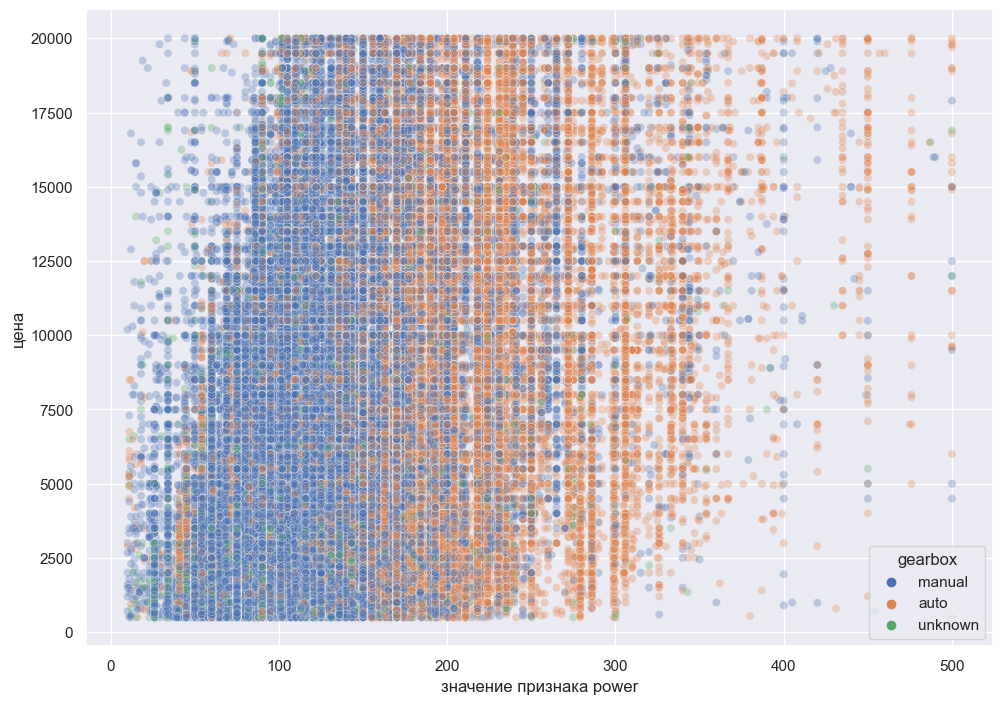

C:\Users\Maxim\anaconda3\envs\practicum\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


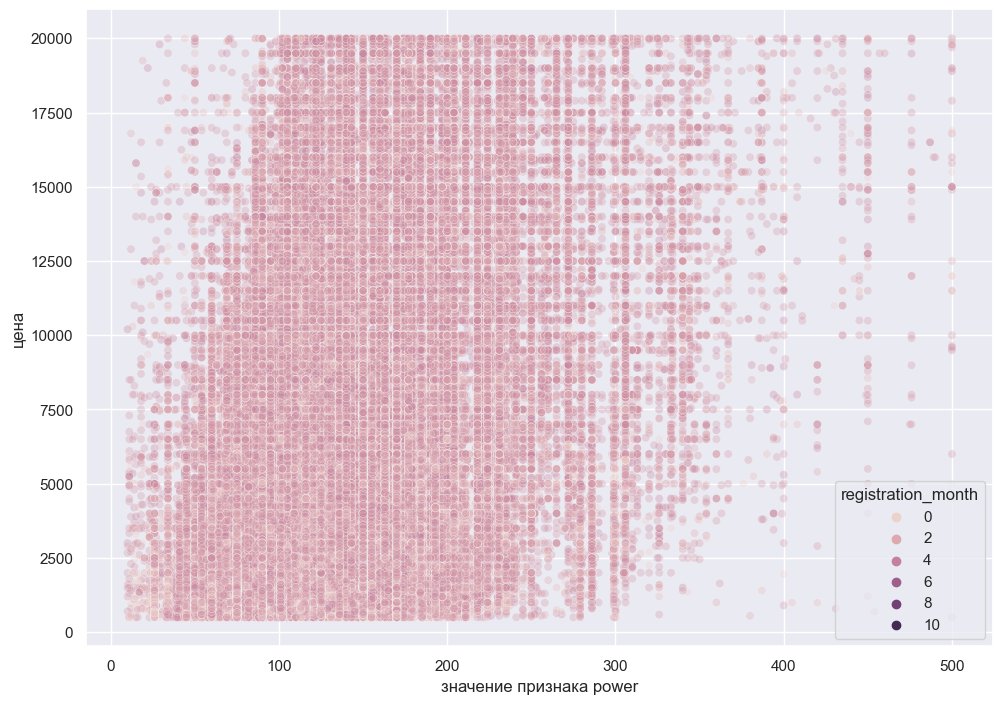

C:\Users\Maxim\anaconda3\envs\practicum\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


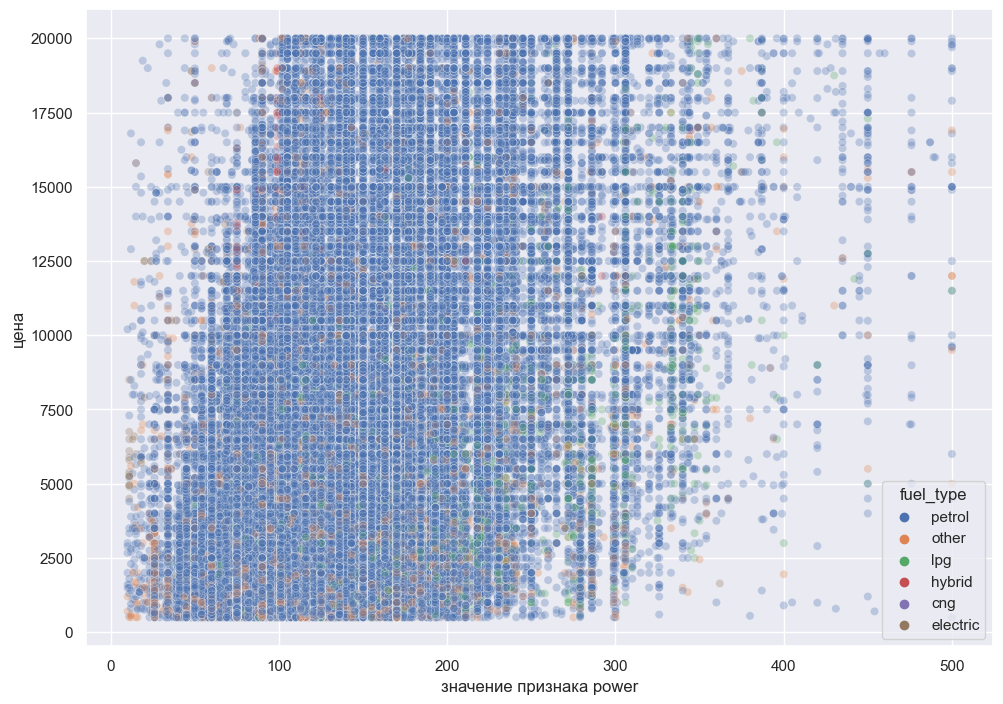

C:\Users\Maxim\anaconda3\envs\practicum\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


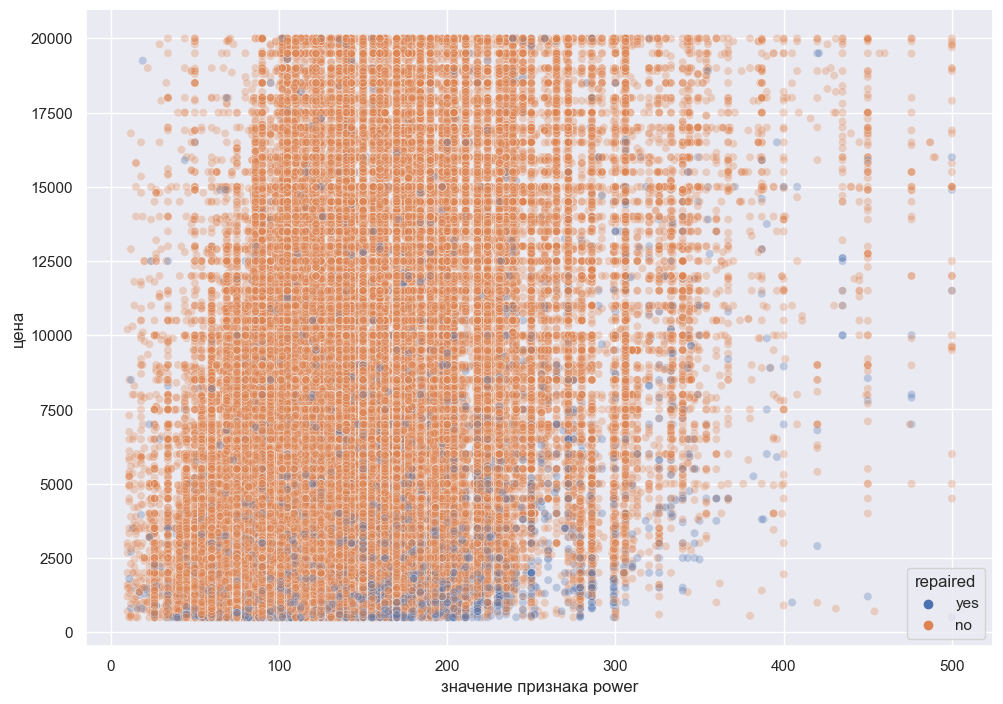

C:\Users\Maxim\anaconda3\envs\practicum\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


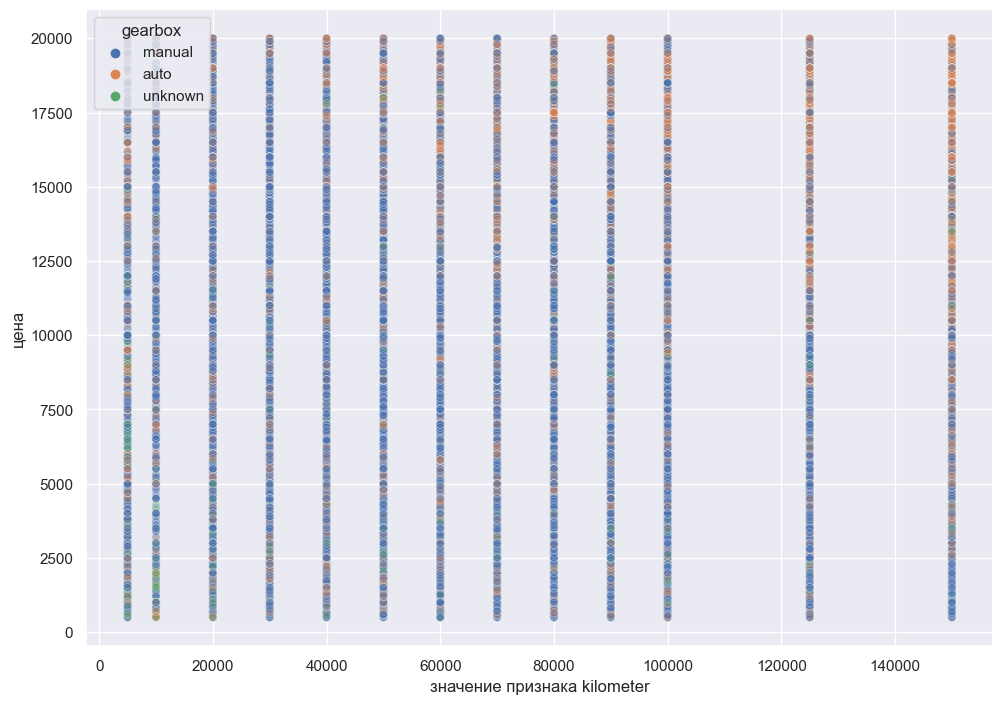

C:\Users\Maxim\anaconda3\envs\practicum\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


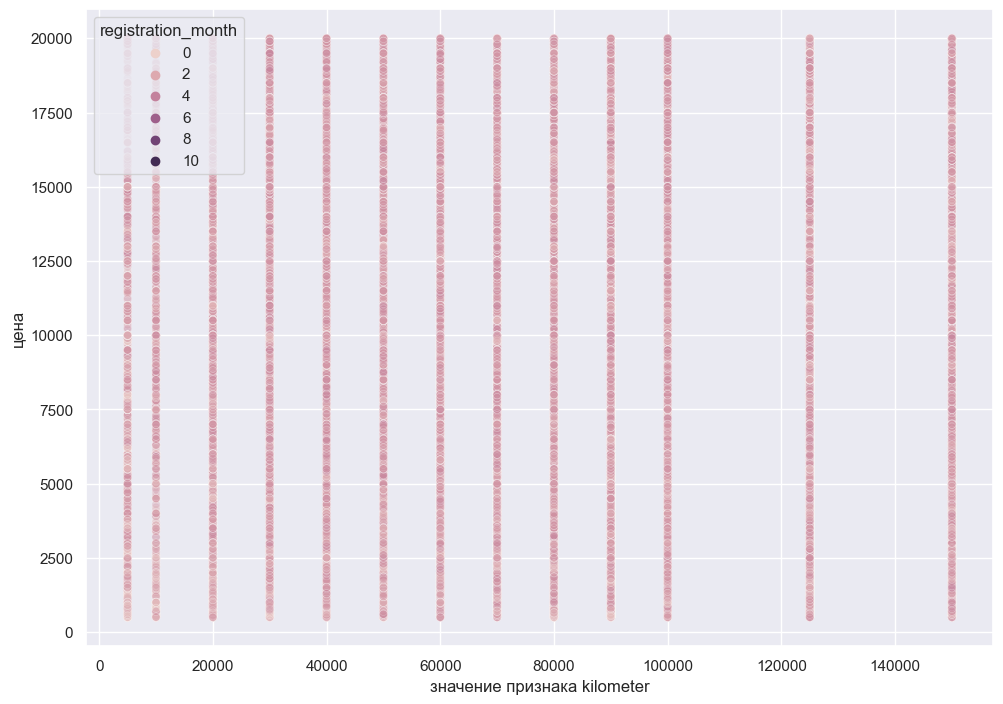

C:\Users\Maxim\anaconda3\envs\practicum\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


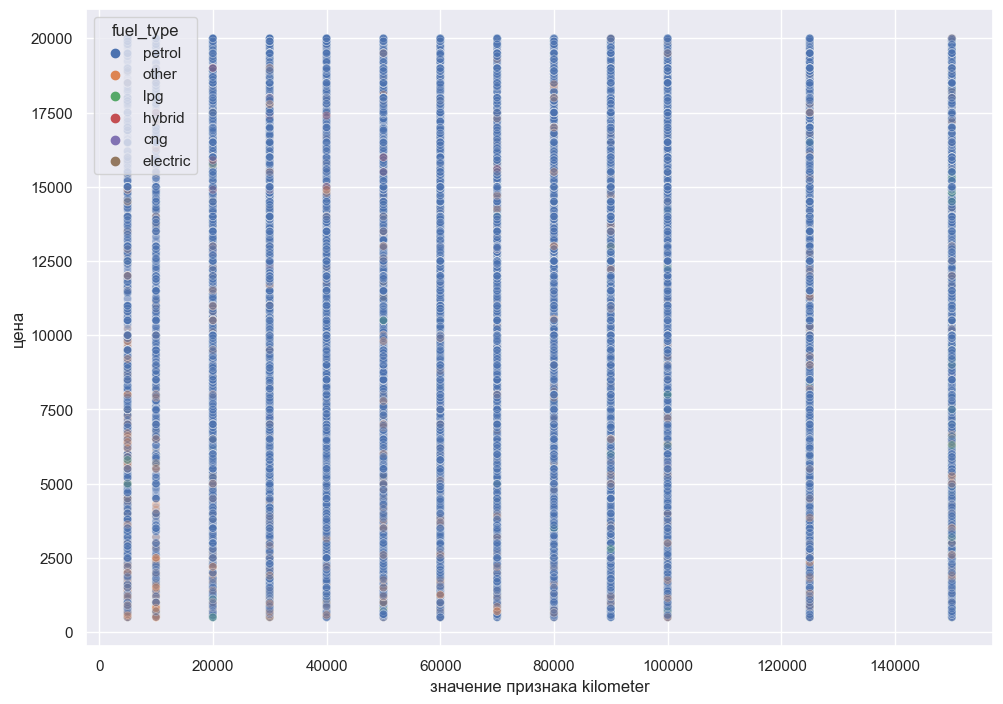

C:\Users\Maxim\anaconda3\envs\practicum\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


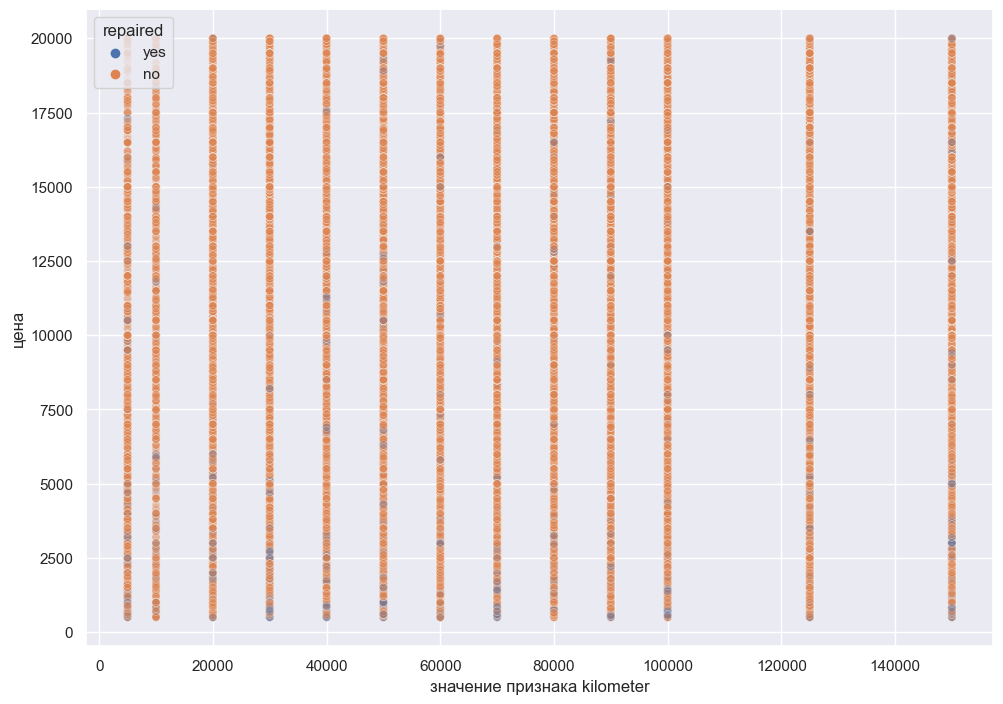

In [64]:
for col_num in df.drop(columns=['registration_year', 'registration_month', 'postal_code', 'price', 'number_of_pictures']).select_dtypes(include='number').columns:
    for col_cat in df[['gearbox', 'registration_month', 'fuel_type', 'repaired']].columns:
        ax = sns.scatterplot(data=df, x=col_num, y='price', hue=col_cat, alpha=0.3)
        plt.ylabel('цена')
        plt.xlabel('значение признака ' + col_num)
        plt.show()

Построенные скаттер плоты подтверждают маьрицу корреляций, из интресного можно заметить, что основая масса автомобилей с максимальным пробегом - на газе. Это особо не относится к исследованию моделей, но все же интресно

**Вывод по пункту**
- на этапе предобработки было сделано:
    1. поработали с именами столбцов
    2. обработаны пропуски
    3. проведена работа с типами данных
- на этапе исследовательского анализа данных
    1. обработаны выбросы
    2. изучены распределения признаков
- на этапе корреляционного анализа было сделано
    1. установлены зависимости с таргетом

## Обучение моделей

### Feature engeneering

Начнем с того что подропаем неинофрмативные признаки

Повторим причину дропа каждого признака:
- дата скачивания и дата последней активности однозначно никак не определяют автомобиль, ровно как и индекс владельца
- количество фотографий везде 0, так что тоже не имеет смысла 

In [65]:
df = df.drop(columns=['date_crawled', 'number_of_pictures', 'postal_code', 'last_seen', 'date_created', 'registration_month'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 297736 entries, 1 to 332340
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   price              297736 non-null  int64  
 1   vehicle_type       297736 non-null  object 
 2   registration_year  297736 non-null  int64  
 3   gearbox            297736 non-null  object 
 4   power              297736 non-null  float64
 5   model              297736 non-null  object 
 6   kilometer          297736 non-null  int64  
 7   fuel_type          297736 non-null  object 
 8   brand              297736 non-null  object 
 9   repaired           297736 non-null  object 
dtypes: float64(1), int64(3), object(6)
memory usage: 33.0+ MB


In [66]:
df.duplicated().sum()

34756

In [67]:
df = df.drop_duplicates().reset_index(drop=True)
df.duplicated().sum()

0

Как и было сказано для задач регрессии, кто бы что ни говорил, а таргету лучше быть нормально распределенным.<br>
**UPD**: видимо из за выбросов или еще по какой то причине, в данной задаче модель предсказывает точнее без логарифмирования таргета


count    262980.000000
mean       5054.947034
std        4598.791880
min         500.000000
25%        1500.000000
50%        3400.000000
75%        7200.000000
max       20000.000000
Name: price, dtype: float64


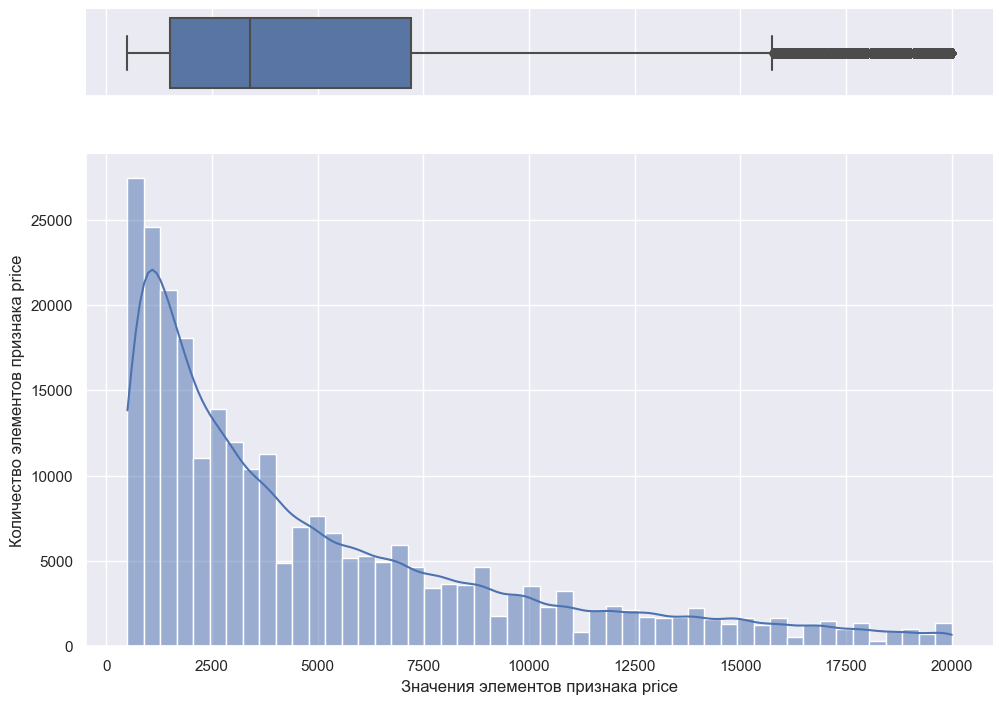

In [68]:
print_hist_box(df['price'].to_frame())

### Подготовка моделей и обучение моделей

Подготовим пайплайны и обучим модели

In [69]:
df.head()

price vehicle_type  registration_year gearbox  power    model  kilometer  \
0  18300        coupe               2011  manual  190.0  unknown     125000   
1   9800          suv               2004    auto  163.0    grand     125000   
2   1500        small               2001  manual   75.0     golf     150000   
3   3600        small               2008  manual   69.0    fabia      90000   
4    650        sedan               1995  manual  102.0      3er     150000   

  fuel_type       brand repaired  
0    petrol        audi      yes  
1    petrol        jeep       no  
2    petrol  volkswagen       no  
3    petrol       skoda       no  
4    petrol         bmw      yes

In [70]:
ohe_cols = ['repaired', 'gearbox', 'fuel_type']
ord_cols = ['model', 'registration_year', 'brand', 'vehicle_type', 'kilometer']
num_cols = df.select_dtypes(include='number').drop(columns=['registration_year', 'kilometer', 'price']).columns # just powed =)

In [71]:
ohe_pl = Pipeline(
    [
        ('ohe_imp', SimpleImputer(strategy='most_frequent', missing_values=np.nan)),
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'))
    ]
)

ord_pl = Pipeline( # we use ordinal here because of big variety of each feature
    [
        ('ord_imp', SimpleImputer(strategy='most_frequent', missing_values=np.nan)),
        ('ord', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)),
        ('ord_imp_post', SimpleImputer(strategy='most_frequent', missing_values=np.nan))
    ]
)

col_transformer = ColumnTransformer(
    [
        ('ohe', ohe_pl, ohe_cols),
        ('ord', ord_pl, ord_cols),
        ('num', StandardScaler(), num_cols)
    ],
    remainder='passthrough'
)

In [72]:
final_pl = Pipeline(
    [
        ('prep', col_transformer),
        ('models', LinearRegression())
    ]
)

In [73]:
X = df.drop(columns=['price'])
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

Попробуем обучить модель линейной регрессии, решащего деререва и 3-х различных реализаций градиентного бустинга: 
- `CatBoostRegressor`
- `LGBMRegressor`
- `XGBRegressor`
Для каждого подберем гиперпараметры с помощью нескольких запусков `GridSearchCV`<br>
*Да, может быть обучается долго, но тут я попытался показать, что тут тоже подбираю гиперпараметры. Почему такие параметры: например для max_depth: я изначально делаю range(2, 10), потом, если вижу, что значение лучшей модели упирается вправо, то увеличиваю правую границу, и так запускаю пайплайн и GridSearchCV много раз, при этом слежу, чтобы модель не переобучилась. Отсюда и такие значения*

In [74]:
params = [
    {
        'models': [CatBoostRegressor(random_state=42, verbose=10), 
                   LGBMRegressor(random_state=42)],
        'models__learning_rate':  [0.1, 0.25], 
        'models__max_depth': [10, 12],
        'models__n_estimators': [200], 
        'prep__num': ['passthrough']
    },
    {
        'models': [XGBRegressor(random_state=42)],
        'models__learning_rate':  [0.1, 0.12],
        'models__max_depth': [10, 12],
        'models__n_estimators': [200],
        'prep__num': ['passthrough']
    },
    {
        'models': [DecisionTreeRegressor(random_state=42)],
        'models__max_depth': range(3, 5),
        'models__min_samples_split': range(3, 5),
        'models__min_samples_leaf': range(3, 5),
        'prep__num': ['passthrough']
    }
]

In [75]:
search = GridSearchCV(
    final_pl,
    param_grid=params,
    n_jobs=-1,
    scoring='neg_root_mean_squared_error',
)

In [76]:
search.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('ohe_imp',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore'))]),
                                                                         ['repaired',
                                                                          'gearbox',
                                                                          'fuel_type']),
                                                                        ('ord',
                                                                         Pipeline(steps=[('ord_imp',
                                                                                          SimpleImputer(strategy='most_frequent'))...
                                                  random_state=42, ...)],
                          'models__learning_rate': [0.1, 0.12],
                          'models__max_depth': [10, 12],
                          'models__n_estimators': [200],
                          'prep__num': ['passthrough']},
                         {'models': [DecisionTreeRegressor(random_state=42)],
                          'models__max_depth': range(3, 5),
                          'models__min_samples_leaf': range(3, 5),
                          'models__min_samples_split': range(3, 5),
                          'prep__num': ['passthrough']}],
             scoring='neg_root_mean_squared_error')

In [77]:
search.best_estimator_

Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe_imp',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['repaired', 'gearbox',
                                                   'fuel_type']),
                                                 ('ord',
                                                  Pipeline(steps=[('ord_imp',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=10, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=200, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

In [78]:
np.abs(search.best_score_)

1707.448941348941

In [79]:
search.best_params_

{'models': XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...),
 'models__learning_rate': 0.1,
 'models__max_depth': 10,
 'models__n_estimators': 200,
 'prep__num': 'passthrough'}

На кросс валидации получаем RMSE = 1707.4. На самом деле это немало с учетом того, что у нас цены на автомобиль достигают максимум 20000. Но как еще улучшать модель так, что бы метрика сильно возрасла, я не не знаю. Думаю, что проблема как раз в данных. Что много странных объявлений, и даже несмотря на то, что большую часть почистили, все равно остались странные объявления

**Вывод по пукту**
- были подготовлены пайплайны для обучения
- были обучены:
- модель линейной регрессии
- модель решащего деререва
- 3-х различных реализаций гградиентного бустинга: 
    1. `CatBoostRegressor`
    2. `LGBMRegressor`
    3. `XGBRegressor`<br>
Для каждого подобраны гиперпараметры с помощью нескольких запусков `GridSearchCV`<br>
Лучшей стала модель `XGBRegressor` со значением метрики 1976.1 при кросс валидации.

## Анализ моделей

Итак, в прошлом пункте мы получили лучшую модель по метрике - `XGBRegressor`. Посмотрим теперь на другие необзодимые параметры моделей, необходимые заказчику - время обучения и время предсказания. Будем сравнивать лучшие модели по качеству:

In [80]:
pd.DataFrame(search.cv_results_).\
                                sort_values(by='mean_test_score', ascending=False)\
                                        [['mean_fit_time', 'std_fit_time', 'mean_score_time',	'std_score_time', 'param_models', 'mean_test_score', 'std_test_score']]

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
8       13.737239      0.432996         1.359765        0.510627   
10      20.491187      2.893931         1.566811        0.365540   
3       43.401781     12.106771         0.540156        0.062190   
9       31.265121      2.904687         4.474207        1.296226   
2       54.841445      1.607818         0.969410        0.195228   
11      25.092990      2.978263         2.441074        0.492419   
6       75.053194     39.203525         0.347671        0.054079   
7      103.709054      1.539850         0.375595        0.094452   
1       68.612826      2.029653         0.696937        0.100918   
5       54.513677     36.997555         0.445609        0.085458   
0       54.689052      1.607606         1.019475        0.182414   
4       39.501596      3.037728         0.459372        0.058442   
16       3.296787      0.178893         0.425063        0.045299   
17       3.569258      0.063734         0.509837        0.066836   
18       3.602369      0.104750         0.441221        0.037490   
19       2.579305      0.424897         0.238961        0.052851   
12       2.879103      0.149983         0.384372        0.051118   
13       2.933957      0.080539         0.390556        0.012434   
14       3.175524      0.087369         0.388162        0.025864   
15       2.897454      0.068357         0.410104        0.060378   

                                         param_models  mean_test_score  \
8   XGBRegressor(base_score=None, booster=None, ca...     -1707.448941   
10  XGBRegressor(base_score=None, booster=None, ca...     -1711.243220   
3   <catboost.core.CatBoostRegressor object at 0x0...     -1730.013910   
9   XGBRegressor(base_score=None, booster=None, ca...     -1736.417324   
2   <catboost.core.CatBoostRegressor object at 0x0...     -1739.890269   
11  XGBRegressor(base_score=None, booster=None, ca...     -1742.051300   
6                      LGBMRegressor(random_state=42)     -1744.377498   
7                      LGBMRegressor(random_state=42)     -1744.597210   
1   <catboost.core.CatBoostRegressor object at 0x0...     -1755.698925   
5                      LGBMRegressor(random_state=42)     -1775.707902   
0   <catboost.core.CatBoostRegressor object at 0x0...     -1776.284102   
4                      LGBMRegressor(random_state=42)     -1776.590191   
16             DecisionTreeRegressor(random_state=42)     -2818.191397   
17             DecisionTreeRegressor(random_state=42)     -2818.191397   
18             DecisionTreeRegressor(random_state=42)     -2818.191397   
19             DecisionTreeRegressor(random_state=42)     -2818.191397   
12             DecisionTreeRegressor(random_state=42)     -3111.750273   
13             DecisionTreeRegressor(random_state=42)     -3111.750273   
14             DecisionTreeRegressor(random_state=42)     -3111.750273   
15             DecisionTreeRegressor(random_state=42)     -3111.750273   

    std_test_score  
8        11.859630  
10        9.398823  
3         9.260733  
9         6.273210  
2         8.803519  
11        6.221100  
6         9.876989  
7        11.278309  
1         6.533183  
5         8.354307  
0         8.218929  
4         8.486271  
16       11.461599  
17       11.461599  
18       11.461599  
19       11.461599  
12       11.898574  
13       11.898574  
14       11.898574  
15       11.898574

Видим, что наша лучшая подель по скору быстрее всего учиться и быстрее всего предсказывает (выстрее среди бустингов). Причем и стандартные отклонения тоже минимальны. На втором месте `CatBoost`. Перепроверим данные о скорости обучения и предсказания у нашей луйшей модели

In [81]:
%%time
search.best_estimator_.fit(X_train, y_train)

CPU times: total: 26.1 s
Wall time: 2.72 s


Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe_imp',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['repaired', 'gearbox',
                                                   'fuel_type']),
                                                 ('ord',
                                                  Pipeline(steps=[('ord_imp',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=10, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=200, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

In [82]:
%%time
search.best_estimator_.predict(X_test)

CPU times: total: 1.25 s
Wall time: 237 ms


array([3389.615 , 1089.9886, 3476.1038, ..., 2953.9158, 2629.2449,
       3059.7222], dtype=float32)

Обучение занимает ~ 20 секунд процессорного времени и ~ 2.5 секунды "настенного времени", то есть часы, находящиеся за пределами ПК посчитаю 2.2 секунды.<br>
Предсказание занимает ~ 1 секунду процессорного времени и ~ 200 мс "настенного времени"

ну и выполним еще раз предсказание на тестовой выборке и посчитаем RMSE:

In [83]:
root_mean_squared_error(y_test, search.predict(X_test))

1697.622444607551

In [84]:
cvr = pd.DataFrame(search.cv_results_)
cvr

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       54.689052      1.607606         1.019475        0.182414   
1       68.612826      2.029653         0.696937        0.100918   
2       54.841445      1.607818         0.969410        0.195228   
3       43.401781     12.106771         0.540156        0.062190   
4       39.501596      3.037728         0.459372        0.058442   
5       54.513677     36.997555         0.445609        0.085458   
6       75.053194     39.203525         0.347671        0.054079   
7      103.709054      1.539850         0.375595        0.094452   
8       13.737239      0.432996         1.359765        0.510627   
9       31.265121      2.904687         4.474207        1.296226   
10      20.491187      2.893931         1.566811        0.365540   
11      25.092990      2.978263         2.441074        0.492419   
12       2.879103      0.149983         0.384372        0.051118   
13       2.933957      0.080539         0.390556        0.012434   
14       3.175524      0.087369         0.388162        0.025864   
15       2.897454      0.068357         0.410104        0.060378   
16       3.296787      0.178893         0.425063        0.045299   
17       3.569258      0.063734         0.509837        0.066836   
18       3.602369      0.104750         0.441221        0.037490   
19       2.579305      0.424897         0.238961        0.052851   

                                         param_models  \
0   <catboost.core.CatBoostRegressor object at 0x0...   
1   <catboost.core.CatBoostRegressor object at 0x0...   
2   <catboost.core.CatBoostRegressor object at 0x0...   
3   <catboost.core.CatBoostRegressor object at 0x0...   
4                      LGBMRegressor(random_state=42)   
5                      LGBMRegressor(random_state=42)   
6                      LGBMRegressor(random_state=42)   
7                      LGBMRegressor(random_state=42)   
8   XGBRegressor(base_score=None, booster=None, ca...   
9   XGBRegressor(base_score=None, booster=None, ca...   
10  XGBRegressor(base_score=None, booster=None, ca...   
11  XGBRegressor(base_score=None, booster=None, ca...   
12             DecisionTreeRegressor(random_state=42)   
13             DecisionTreeRegressor(random_state=42)   
14             DecisionTreeRegressor(random_state=42)   
15             DecisionTreeRegressor(random_state=42)   
16             DecisionTreeRegressor(random_state=42)   
17             DecisionTreeRegressor(random_state=42)   
18             DecisionTreeRegressor(random_state=42)   
19             DecisionTreeRegressor(random_state=42)   

   param_models__learning_rate param_models__max_depth  \
0                          0.1                      10   
1                          0.1                      12   
2                         0.25                      10   
3                         0.25                      12   
4                          0.1                      10   
5                          0.1                      12   
6                         0.25                      10   
7                         0.25                      12   
8                          0.1                      10   
9                          0.1                      12   
10                        0.12                      10   
11                        0.12                      12   
12                         NaN                       3   
13                         NaN                       3   
14                         NaN                       3   
15                         NaN                       3   
16                         NaN                       4   
17                         NaN                       4   
18                         NaN                       4   
19                         NaN                       4   

   param_models__n_estimators param_prep__num param_models__min_samples_leaf  \
0                         200     passthrough                            NaN  

In [85]:
cvr['param_models'] = cvr['param_models'].apply(lambda x: str(x).split(' ')[0].split('(')[0])
cvr

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       54.689052      1.607606         1.019475        0.182414   
1       68.612826      2.029653         0.696937        0.100918   
2       54.841445      1.607818         0.969410        0.195228   
3       43.401781     12.106771         0.540156        0.062190   
4       39.501596      3.037728         0.459372        0.058442   
5       54.513677     36.997555         0.445609        0.085458   
6       75.053194     39.203525         0.347671        0.054079   
7      103.709054      1.539850         0.375595        0.094452   
8       13.737239      0.432996         1.359765        0.510627   
9       31.265121      2.904687         4.474207        1.296226   
10      20.491187      2.893931         1.566811        0.365540   
11      25.092990      2.978263         2.441074        0.492419   
12       2.879103      0.149983         0.384372        0.051118   
13       2.933957      0.080539         0.390556        0.012434   
14       3.175524      0.087369         0.388162        0.025864   
15       2.897454      0.068357         0.410104        0.060378   
16       3.296787      0.178893         0.425063        0.045299   
17       3.569258      0.063734         0.509837        0.066836   
18       3.602369      0.104750         0.441221        0.037490   
19       2.579305      0.424897         0.238961        0.052851   

                        param_models param_models__learning_rate  \
0   <catboost.core.CatBoostRegressor                         0.1   
1   <catboost.core.CatBoostRegressor                         0.1   
2   <catboost.core.CatBoostRegressor                        0.25   
3   <catboost.core.CatBoostRegressor                        0.25   
4                      LGBMRegressor                         0.1   
5                      LGBMRegressor                         0.1   
6                      LGBMRegressor                        0.25   
7                      LGBMRegressor                        0.25   
8                       XGBRegressor                         0.1   
9                       XGBRegressor                         0.1   
10                      XGBRegressor                        0.12   
11                      XGBRegressor                        0.12   
12             DecisionTreeRegressor                         NaN   
13             DecisionTreeRegressor                         NaN   
14             DecisionTreeRegressor                         NaN   
15             DecisionTreeRegressor                         NaN   
16             DecisionTreeRegressor                         NaN   
17             DecisionTreeRegressor                         NaN   
18             DecisionTreeRegressor                         NaN   
19             DecisionTreeRegressor                         NaN   

   param_models__max_depth param_models__n_estimators param_prep__num  \
0                       10                        200     passthrough   
1                       12                        200     passthrough   
2                       10                        200     passthrough   
3                       12                        200     passthrough   
4                       10                        200     passthrough   
5                       12                        200     passthrough   
6                       10                        200     passthrough   
7                       12                        200     passthrough   
8                       10                        200     passthrough   
9                       12                        200     passthrough   
10                      10                        200     passthrough   
11                      12                        200     passthrough   
12                       3                        NaN     passthrough   
13                       3                        NaN     passthrough   
14                       3                        N

In [86]:
idxs = cvr.groupby('param_models')['mean_test_score'].idxmax() # indexes
idxs.reset_index(drop=True)

0     3
1    16
2     6
3     8
Name: mean_test_score, dtype: int64

In [87]:
cvr.loc[idxs.values][['param_models', 'mean_fit_time', 'mean_score_time', 'mean_test_score']]

param_models  mean_fit_time  mean_score_time  \
3   <catboost.core.CatBoostRegressor      43.401781         0.540156   
16             DecisionTreeRegressor       3.296787         0.425063   
6                      LGBMRegressor      75.053194         0.347671   
8                       XGBRegressor      13.737239         1.359765   

    mean_test_score  
3      -1730.013910  
16     -2818.191397  
6      -1744.377498  
8      -1707.448941

In [88]:
dummy_pl = Pipeline(
    [
        ('prep', col_transformer),
        ('models', DummyRegressor())
    ]
)
dummy_pl.fit(X_train, y_train)
root_mean_squared_error(y_test, dummy_pl.predict(X_test))

4599.162985001582

## Вывод

В данном проекте были проанализированы данные об анкетах о продаже авто.<br>
- на этапе предобработки было сделано:
    1. поработали с именами столбцов
    2. обработаны пропуски
    3. проведена работа с типами данных
- на этапе исследовательского анализа данных
    1. обработаны выбросы
    2. изучены распределения признаков
- на этапе корреляционного анализа было сделано
    1. установлены зависимости с таргетом
- на этапе подготовки данных к обучению было сделано:
    - были подготовлены пайплайны для обучения
    - были обучены:
    - модель линейной регрессии
    - модель решащего деререва
    - 3-х различных реализаций гградиентного бустинга: 
        1. `CatBoostRegressor`
        2. `LGBMRegressor`
        3. `XGBRegressor`<br>
Для каждого подобраны гиперпараметры с помощью нескольких запусков `GridSearchCV`<br>
Лучшей по скору стала модель `XGBRegressor` со значением метрики 1697.6 на тестовой выборке.
Проанализировав и другие модели, мы поняли, что оптимальным решением для заказчика станет как раз наша лучшая модель с результатми:
- Обучение занимает ~ 15 секунд процессорного времени и ~ 2.5 секунды "настенного времени", то есть часы, находящиеся за пределами ПК посчитаю 2.2 секунды.<br>
- Предсказание занимает ~ 1 секунду процессорного времени и ~ 200 мс "настенного времени"